In [1]:
#Append path to Ruomin's Edamame Package (Nanowire Simulations)
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')
saveFig='/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
import pandas as pd
import skspatial
from skspatial.objects import Plane, Points
from skspatial.plotting import plot_3d
import copy

from scipy.io import loadmat, savemat
from scipy import signal

#Import Ruomin's package
from edamame import * 

#import networkx for visualisation of networks
import networkx as nx

#tqdm allows for progress bars
from tqdm.notebook import tqdm_notebook as tqdm

import os
from IPython.core.debugger import set_trace
import matplotlib.colors as clrs


In [3]:
# GENERATE + LOAD CSV FILE OF IMAGES:
from learning_functions import generate_data, load_data
orig_inputs=generate_data()
inputs,onehot_outputs,sample_num,targets=load_data()
target_letters=['z','v','n']

In [4]:
from learning_functions import genGridNW,point_on_line,dist,getWeightedGraph

In [5]:
#load SPARSE network
#Not you need this file in a folder called Sparse Networks 
# asn_nw_00300_nj_00621_seed_1252_avl_10.00_disp_01.00_lx_100.00_ly_100.00
#asn_nw_00350_nj_01400_seed_2665_avl_10.00_disp_01.00_lx_50.00_ly_50.00
#asn_nw_00250_nj_00794_seed_134_avl_10.00_disp_01.00_lx_50.00_ly_50.00
nw=loadmat('../Sparse Networks/asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00')
this_seed=8639#np.random.randint(10000) #random seed
Network=nw#edamame.core.generate_network(300,dispersion=350,mean_length=200,this_seed=this_seed)
connectivity=connectivity__(wires_dict=Network) 

In [41]:
#fixing file structure from Matlab:
connectivity.avg_length=connectivity.avg_length[0][0]
connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
connectivity.dispersion=connectivity.dispersion[0][0]
# connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
connectivity.length_x=connectivity.length_x[0][0]
connectivity.length_y=connectivity.length_y[0][0]
connectivity.number_of_wires=connectivity.number_of_wires[0][0]
connectivity.numOfWires=connectivity.numOfWires[0][0]
connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
connectivity.theta=connectivity.theta[0][0]
connectivity.this_seed=connectivity.this_seed[0][0]

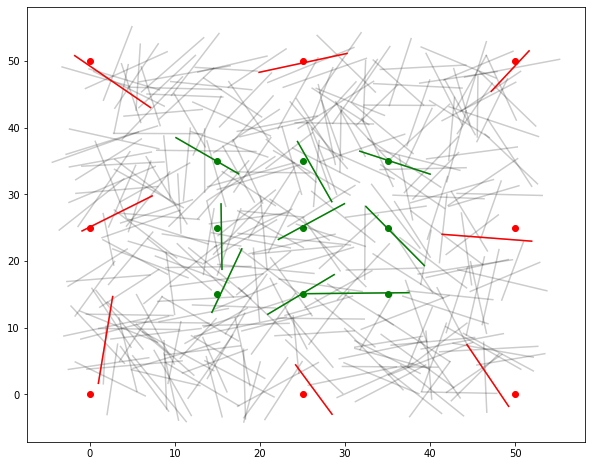

In [42]:
#Generate Network
%matplotlib inline

#find x and y values of each end of each wire 
xa=connectivity.xa[0]
xb=connectivity.xb[0]
ya=connectivity.ya[0]
yb=connectivity.yb[0]

#Pick Electrode placement/distance apart:

#DRAINS
numDrains=8

#IN A LINE:
# ex=np.ones(numDrains)*5#*15
# # ey=np.linspace(0,550,numDrains)
# ey=np.linspace(-1,51,numDrains)#(50,100,numDrains)

# IN A GRID:
middleNWx=int(connectivity.length_x/2)
middleNWy=int(connectivity.length_y/2)
distBwElecs=25
ex=[middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx,middleNWx,middleNWx+distBwElecs,middleNWx+distBwElecs,middleNWx+distBwElecs]
ey=[middleNWy-distBwElecs,middleNWy,middleNWy+distBwElecs]*3
del ey[4]
elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates

plt.figure(figsize=(10,8))
plt.scatter(ex, ey, c = 'r')

#SOURCES
numSources=9


#IN A LINE:
# ex=np.ones(numSources)*51#95
# ey=np.linspace(-2,49,numSources)#(35,100,numSources)
#IN A 3X3 GRID:
middleNWx=int(connectivity.length_x/2)
middleNWy=int(connectivity.length_y/2)
distBwElecs=10
ex=[middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx,middleNWx,middleNWx,middleNWx+distBwElecs,middleNWx+distBwElecs,middleNWx+distBwElecs]
ey=[middleNWy-distBwElecs,middleNWy,middleNWy+distBwElecs]*3

elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates

plt.plot([xa, xb], [ya, yb], c = 'k',alpha=0.2)
plt.plot([xa[elecDrain], xb[elecDrain]], [ya[elecDrain], yb[elecDrain]], c = 'r')
plt.plot([xa[elecSource], xb[elecSource]], [ya[elecSource], yb[elecSource]], c = 'g')

plt.scatter(ex, ey, c = 'g')

# plt.savefig(figLoc+'Network and Electrodes.png',dpi=300)

In [43]:
print('OG Sources:' + str(elecSource))
print('OG Drains:' + str(elecDrain))

OG Sources:[281 243  57 265 316 190  19 334 266]
OG Drains:[209 152 180 181  61 183 145  29]


In [44]:
#MANUAL SOURCES DRAINS IF THERE'S OVERLAP
# elecSource=[23,320,26,74,145,317,129,247,141] 
# elecDrain=[23,29,102,296]

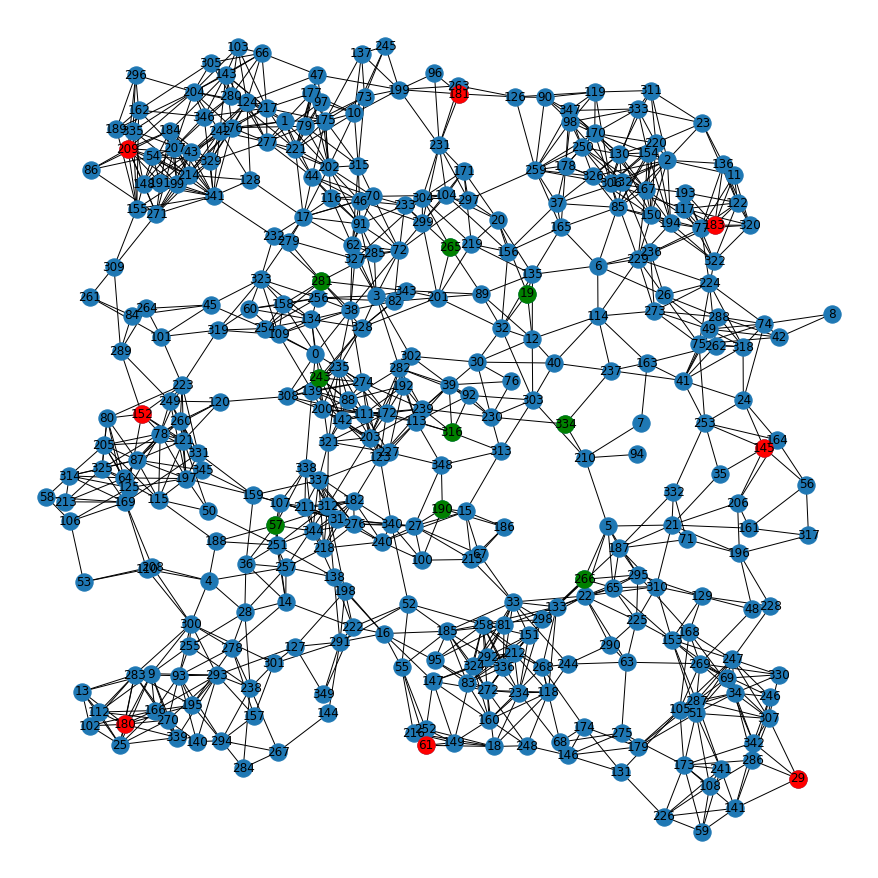

In [45]:
#PLOT GRAPH REPRESENTATION:
plt.figure(figsize=(12,12))
pos=nx.kamada_kawai_layout(nx.from_numpy_array(connectivity.adj_matrix))
nx.draw(nx.from_numpy_array(connectivity.adj_matrix),pos=pos,with_labels=True)
nx.draw_networkx_nodes(elecSource,node_color='g',pos=pos)
nx.draw_networkx_nodes(elecDrain,node_color='r',pos=pos)

## RUN ASSOCIATIVE LEARNING + EQUIL PROP

In [46]:
#This function sets up the stimuli for simulations. 
def setupStimulus(training_stimulus,currInput,run_time=2,onAmp=1,signalType='DC'):

    for i in range(num_drain_training):
        training_stimulus.append((stimulus__(biasType='Drain',T=run_time,dt=dt)))
        
    #Sources
    for i in range(len(currInput)):
        if currInput[i]>0:
            training_stimulus.append((stimulus__(biasType=signalType,onAmp=onAmp*currInput[i],T=run_time,dt=dt)))
#         else: #non-active sources are changed to 0.005 instead of 0, to reduce sink behaviour between sources
#             training_stimulus.append((stimulus__(biasType=signalType,onAmp=0.01,T=run_time,dt=dt)))

    return training_stimulus

In [393]:
#This function sets up the stimuli for the testing part of the simulation. 
def setupSourcesOnly(stim,currInput,onAmp=1,run_time=2,signalType='DC'):
    #Sources
    stimulus=copy.deepcopy(stim)
    for i in range(len(currInput)):
        if currInput[i]>0:
            stimulus.append((stimulus__(biasType=signalType,onAmp=onAmp*currInput[i],T=run_time,dt=dt)))
#         else:
#             stimulus.append((stimulus__(biasType=signalType,onAmp=0.01,T=run_time,dt=dt)))
    return stimulus

In [394]:
#This function runs each training epoch and saves the network state at the last timestep of that epoch

def getNWState(training_stimulus,state,drain_pool,sources,run_time=2):
    eles = np.append(drain_pool, sources) #all drains
#     if len(eles) == num_drain_training + num_source_training:
    training_sim = runSim(connectivity, stimulus = training_stimulus,
                       junctionMode = 'tunneling',
                       dt = dt, T = run_time, 
                       contactMode = 'preSet',
                       electrodes = eles,
                       findFirst = False,
                       start_state = state,
                       disable_tqdm=True)
                       #criticalFlux=0.01)  
    JS1 = getJunctionState(training_sim, -1) #save state
#     else: 
#         print('Bless you Joel :)')
    return training_sim,JS1

In [395]:
#This function calculates the conductance read out at each drain electrode, 
#which we use to determine if the target threshold for each electrode is met

def calcOutputs(sim2, sources,all_drains):
    
    cc = np.zeros(len(all_drains))
    volt = np.zeros(len(all_drains))

#     for i, d in enumerate(all_drains):
#         a = wireCurrentTimeSeries(sim1, d)
#         b = wireCurrentTimeSeries(sim2, d)
#         print(a.shape,b.shape)
#         cc[i] = np.dot(a.reshape(-1),b.reshape(-1))

#     cc=(cc-minval)/(maxval-minval)
#       return cc

# ALTERNATIVE METHOD SUGGESTED BY JOEL


#Index network state:
    #IF PULSE - we want the state of the network at the end of the last pulse 
    if sim2.stimulus[-1].biasType=='Pulse':
        t=sim2.stimulus[-1].signal>0.005
        idx=[i for i, x in enumerate(t) if x][-1]
    else: #otherwise we take 4 timesteps as the state of the network 
#         idx=[500,1000,1500,-1]
        idx=-1
        
        
#Calculate Current at network state: 
    for i, d in enumerate(all_drains): #for each drain electrode
        #current
        cc[i]=sim2.electrodeCurrent.T[i][idx]#/(sim2.wireVoltage.T[sources[0]][idx]-sim2.wireVoltage.T[d][idx])
        #resistance
        volt[i]=sim2.wireVoltage.T[d][idx]#/sim2.electrodeCurrent.T[i][idx]
        
        # Conductance = Current Drain / (Voltage Source - Voltage Drain)
    return cc,volt


In [396]:
#Calculate cost function
def calc_cost(x,y):
    return (1/2)*((x-y)**2)
#we need to account for the fact where some non-target drains will have -ve current that impacts the +ve current drains

In [397]:
#This function changes the write voltage of the drain electrodes. This is where we tune the system so that 
#it prioritises/de-prioritises certain pathways based on targets and non-targets
def change_voltage(stim,sim2,outputVals,target_index,th=0,th2=0,signalType='DC'):
    import copy
    stimulus=copy.deepcopy(stim)
    
    Vi        = np.zeros((int(run_time/dt)))
    maxV      = onAmp*0.75
    n         = len(outputVals)
    cost      = np.zeros(n)
    beta      = 0.1 #change the values here
    grad      = np.zeros((n))
    dsig    = np.array([stimulus[i].signal for i in range(len(stimulus))][:num_drain_training])
    
    #vectorised implementation
    cost=calc_cost(outputVals,target_values) 
    
#     if gradOff == False: #
    grad=beta*(outputVals-target_values) 
#     elif gradOff == True: #if we have hit currents target
#         grad=0
    dsig2=dsig.T+(grad*onAmp)
    for i in range(n): # for each drain:
        if stimulus[i].signal[0] <= maxV and stimulus[i].signal[0] >= -maxV:
            stimulus[i].signal=dsig2.T[i]
    
    print('Costs '+str(cost))
    print('Sum Cost '+str((np.sum(cost))))
    print('Gradients '+str(grad))
    return outputVals,stimulus,cost

In [398]:
#This function combines all the training functions into one step:

def runSimulations(stimulus,state,signalType,run_time=2):
    #first we run the training for this epoch, and get the network state at the last timestep:
    simulation,new_state = getNWState(stimulus,state,drain_pool,onSources,run_time=run_time) 
    #we then calculate the drain currents at that network state
    t,v      = calcOutputs(simulation,sources,drain_pool)
    return t,v,new_state,simulation

#This is how we test new inputs - only care about cost
def runTesting(outputVals,th,th2):
    n     = len(outputVals)   
    cost=calc_cost(outputVals,target_values) 
    return cost


### TRAINING

In [52]:
sources = elecSource
drain_pool = elecDrain
allTargets=onehot_outputs

In [53]:
#IF WE WANT ONLY SAMPLES WITH NO NOISE (ORIGINAL Z,V,N)
NoNoiseInputs=[]
for targetClass in range(3):
    NoNoiseInputs.append([int(i) for i in orig_inputs[targetClass]])

In [382]:
#Global Variables
outputs              = {'cost':[],'current':[],'normcurrent':[],'randseed':[],'state':[],'stimulus':[],'target':[]}
numSamples           = 50 #number of random samples from same class
seed                 = 42 #random seed
epochs               = 10 #number of 'training' to run max, unless we hit 0.1 first
thisNwState          = None #inital network state
network_state        = [[[] for i in range(epochs)] for i in range(numSamples)]
avg_filament_state   = [[[] for i in range(epochs)] for i in range(numSamples)]
maxCurr              = [[[] for i in range(epochs)] for i in range(numSamples)]
np.random.seed(seed)
minCurrent           = 0 #~~ 0 
maxCurrent           = 5e-5 # ~~ 1
onAmp                = 0.1 #amplitude for init
run_time             = 10 # time for each iteration
dt                   = 0.001 #timesteps
signalType           ='DC' #Pulse, DC, AC, Square, Sawtooth
numtraining          = 1 #number of training iterations per epoch
num_drain_training   = 8 #total number of drain electrodes
num_source_training  = len(sources) #total number of source electrodes
#With Noise:
# onSources            = np.array(sources)[trainingInputs[1][:-1]>0]
#Without Noise:
onSources            = np.array(sources)[np.array(trainingInputs)>0]


In [383]:
#RUN SIMULATIONS WITHOUT NOISE FOR ALL CLASSES
noNoiseStim=[]
noNoiseSim=[]
for i in tqdm(range(len(NoNoiseInputs))):
    noNoiseStim.append(setupStimulus([], NoNoiseInputs[i],onAmp=0.1,signalType=signalType,run_time=run_time))
    onSources=np.array(sources)[np.array(NoNoiseInputs[i])>0]
    [],[],[],noNoiseSim.append(runSimulations(noNoiseStim[i],None,signalType,run_time=run_time))

<Figure size 640x480 with 0 Axes>

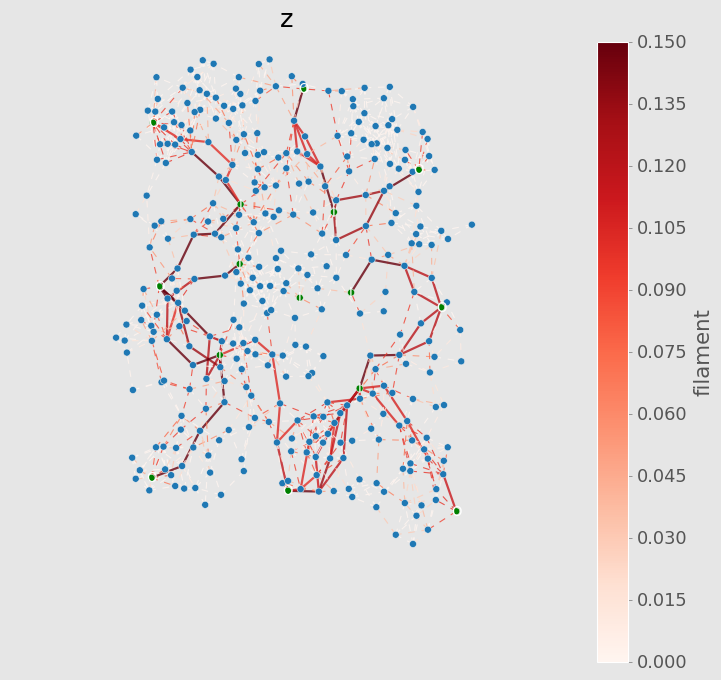

<Figure size 640x480 with 0 Axes>

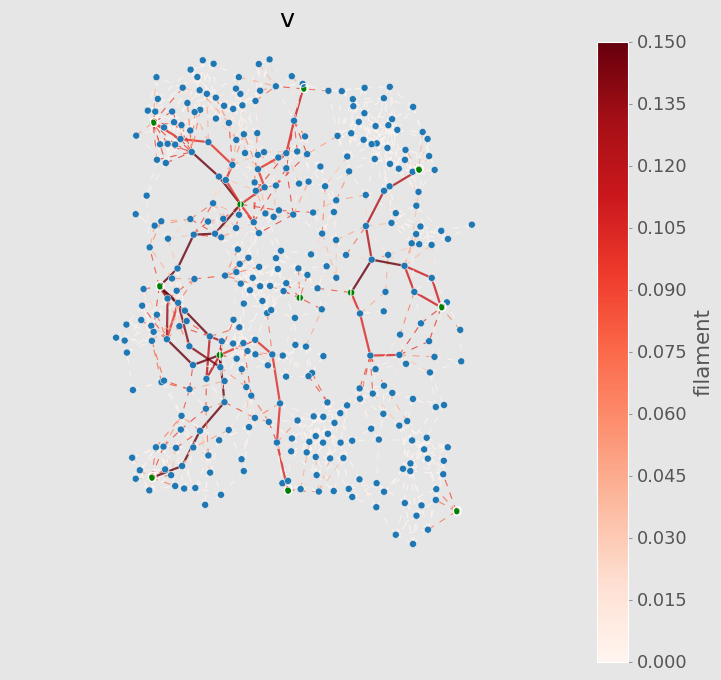

<Figure size 640x480 with 0 Axes>

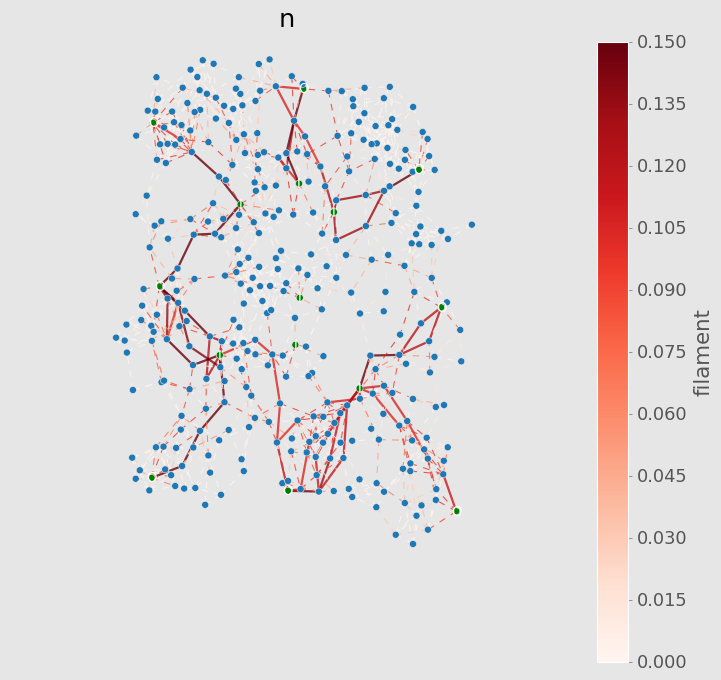

In [384]:
timetoshow=(run_time*1000)-1
for i in range(len(noNoiseSim)):
    plt.figure()
    onSources=np.array(sources)[np.array(NoNoiseInputs[i])>0]
    draw_graph(noNoiseSim[i][-1],edge_colorbar=True,edge_mode='filament',this_TimeStamp=timetoshow,node_size=40,node_highlight=list(np.hstack((onSources,drain_pool))),highlight_color='g',with_labels=False,title=target_letters[i])
    plt.savefig(saveFig+'class_'+target_letters[i]+'_'+str(run_time)+'sec_0p1V_filament_states_free_phase_nonoise_gridElecs.pdf',format='pdf',dpi=300)

In [385]:
vals=[]
maxVals=[]
for i in range(len(noNoiseSim)):
    vals.append(list((noNoiseSim[i][0])))
    vals[i].insert(4,0)
    maxVals.append(np.argsort((np.array(vals[i])),axis=-1)[-3:])
#     vals[i][4]=np.nan

#     maxVals.append(np.nanargmax(np.abs(np.array(vals[i]))))

In [386]:
maxVals #top three values for each letter

[array([7, 5, 1]), array([7, 0, 1]), array([3, 1, 5])]

In [387]:
normVals=[]
currVal=[]
for i in range(len(vals)):
    currVal=copy.deepcopy(vals[i])
    newCurrVal=[]
    for j in range(len(currVal)):
        newCurrVal.append((currVal[j]-np.nanmin(currVal))/(np.nanmax(currVal)-np.nanmin(currVal)))
    normVals.append(newCurrVal)

[Text(0, -0.5, '0'),
 Text(0, 0.0, 'z'),
 Text(0, 0.5, 'v'),
 Text(0, 1.0, 'n'),
 Text(0, 1.5, ''),
 Text(0, 2.0, ''),
 Text(0, 2.5, '')]

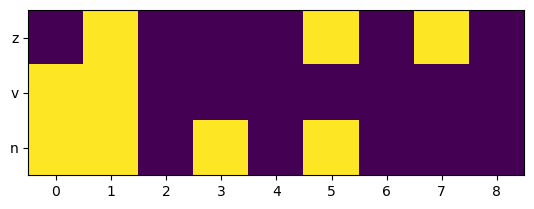

In [388]:
#Which electrodes have absolute current greater than 0.5 (normalised)?
plt.rcParams.update(plt.rcParamsDefault)
plt.imshow(np.array(normVals)>0.5)
ax=plt.gca()
ax.set_yticklabels([0,'z','v','n'])

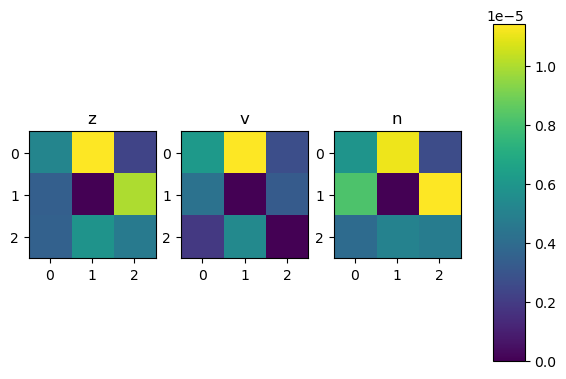

In [389]:
fig,axes=plt.subplots(1,3)

axes[0].imshow((np.array(vals[0])).reshape(3,3))
axes[0].set_title('z')
axes[1].imshow((np.array(vals[1])).reshape(3,3))
axes[1].set_title('v')
a=axes[2].imshow((np.array(vals[2])).reshape(3,3))
axes[2].set_title('n')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(a, cax=cbar_ax)
# plt.colorbar(a,ax=axes[2])

In [390]:
target_values

[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

In [406]:
#Split into Training and Testing:
targetClass     = 1 #'z','v','n'
target_values=np.zeros(9)
for i in range(len(maxVals[targetClass])):
    target_values[maxVals[targetClass][i]]=1
    
target_values=list(target_values)   
del target_values[4]

if len(elecDrain) == 3:
    targetClassVals = [0,1,2]
else:
    targetClassVals = [0,1,2,3,4,5,6,7]
#     target_values   = np.hstack((target_values,[0]*5)) #add extra 0 for 4th drain that acts just to balance the network

#WITH NOISE: 
# trainingInputs  = inputs[targets==targetClassVals[targetClass]][:-2] #training set
# testingInputs   = inputs[targets==targetClassVals[targetClass]][-2:] #test set

#WITHOUT NOISE
trainingInputs = NoNoiseInputs[targetClass]
testingInputs  = NoNoiseInputs

In [399]:
#Run Free Phase:
print('---------- ')
print('Running Free Phase')
print('---------- ')
#trainingInputs[1][:-1]
init_stimulus          = setupStimulus([], trainingInputs,onAmp=onAmp,signalType=signalType,run_time=run_time) #reset stimulus each epoch
initI,initR,initNwState,initSim = runSimulations(init_stimulus,None,signalType,run_time=run_time)

#Run Weakly Clamped Phase
for sample in tqdm(range(numSamples)): #run 100 random samples from the same class in random order
    
    gradOff      = False #turn gradient off?
    target_index = int(targetClassVals[targetClass]) #set target class
    #note - for this testing, I just use the same training sample over and over to make sure the network states are being saved
    val          = 1#np.random.randint(len(trainingInputs)) #choose a random training sample
    currInput    = np.array(trainingInputs)#[val][:-1] #define the input of that training sample
    
    onSources=np.array(sources)[currInput>0]
    offSources=np.array(sources)[currInput==0]
    
    print('---------- ')
    print('Running Weakly Clamped Phase')
    print('---------- ')
    print('Training #'+str(sample+1))
#     print('Training Sample Chosen: '+str(val))
    print('Class ' +str(target_letters[target_index]))
    print('Target ' +str(target_values))
    if sample == 0: #initalise drain stimulus only for first run, after that we use the stimulus from previous samples
        training_stimulus     = []
        sim_stimulus          = setupStimulus(training_stimulus,currInput,onAmp=onAmp,signalType=signalType,run_time=run_time) #reset stimulus each sample
#         Vinit    = sim_stimulus[:3] #save Vd[0] 
    else:
        Vd                    = newStimulus[:num_drain_training] #save previous drains
        sim_stimulus          = setupSourcesOnly(Vd,currInput,onAmp=onAmp,run_time=run_time,signalType=signalType) #setup new sources
    
    signal=[]
    for q in range(8):
        signal.append(sim_stimulus[q].signal[0])
        
    print('Drain Voltages '+str(signal))
    print('Source Voltages '+str(currInput))
    print('---------- ')


    drainI        = np.zeros((epochs,num_drain_training))
    t             = np.zeros((epochs,num_drain_training))
    cost          = np.zeros((epochs,num_drain_training)) 
    
    for i in range(epochs): #for each epoch

        print('Epoch ' + str(i+1))
        if sample == 0 and i == 0: #if we start the first sample and first epoch
            lastNwState=copy.deepcopy(initNwState)
#             thisNwState=None
        elif sample >= 0 and i > 0: #if we move to a new epoch in the current sample
            lastNwState = network_state[sample][i-1] #previous state from previous epoch    
            if lastNwState!=thisNwState:
                print('nw states are not saving properly')
        elif sample > 0 and i==0: #if we move to a new sample that isn't the first sample
            temp=[j for j in network_state[sample-1] if j][-1] #last non empty value in list
            lastNwState = temp #previous state from previous sample        
            if lastNwState!=thisNwState:
                print('nw states are not saving properly')

    
        #run simulation, save currents, resistances, network state and simulation settings
        t[i],v,thisNwState,simulation = runSimulations(sim_stimulus,lastNwState,signalType,run_time=run_time)
        
        avg_filament_state[sample][i]=np.mean(abs(simulation.filamentState),axis=1) #save filament growth
        network_state[sample][i]=thisNwState #save this network state
        
        print('Currents '+str(t[i]))
        #normalise currents:
        # take the log, divide everything by reference, i ~= 1e-8 (arbitrary)

        normT = t[i]/maxCurrent#(t[i]-minCurrent)/(maxCurrent-minCurrent)#(t[i]-np.min(t[i]))/(np.max(t[i])-np.min(t[i]))#np.mean(t[i]))/np.std(t[i])
#         set_trace()
        if i ==0:
            #normalise thresholds:
            th  = 1 #target threshold range + 0.2
            th2 = minCurrent/maxCurrent #non-target threshold range + 0.2
            
        #change the voltages of target and non-target drains to tune the network into using different pathways
        drainI[i,:],newStimulus,cost[i,:] = change_voltage(sim_stimulus,simulation,normT,target_index,th,th2,signalType)
        
        signal=[]
        for q in range(8):
            signal.append(newStimulus[q].signal[0])
        
        print('New Drain Voltages '+str(signal))
        

        #ENDING EPOCHS

        #using winner-takes-all currents
    
        currents2=abs(np.array(normT))
        maxCurr[sample][i]=np.argmax(currents2)
        thisCostSum = np.sum(cost[i,:])
        booltargVals=np.array(target_values).astype('bool')
        
#         print((currents2[booltargVals]-abs(currents2[np.invert(booltargVals)]))/currents2[booltargVals],(currents2[booltargVals]-abs(currents2[np.invert(booltargVals)]))/currents2[booltargVals])
#         if ((currents2[booltargVals]-abs(currents2[np.invert(booltargVals)]))/currents2[booltargVals])>=0.25 and ((currents2[booltargVals]-abs(currents2[np.invert(booltargVals)]))/currents2[booltargVals])>=0.25:
#         #target - nontarget / target >= X%
        
#             print('Target Current significantly larger than non-target currents \n')
# #             gradOff=True
#             break;
#         else:
#             print('Target Current not significantly larger than non-target currents \n')
# #             gradOff=False

        #using total cost less than 0.01:
        
        
        print('cost ' + str(thisCostSum))
        if thisCostSum < 0.1:
            break;
            
    outputs['current'].append(t)
    outputs['normcurrent'].append(drainI)
    outputs['cost'].append(cost)
    outputs['target'].append(target_index)
    outputs['state'].append(network_state[sample])
    outputs['randseed']=seed
#     count+=1
    if thisCostSum < 0.01:
        print('Local Minima Found')
        break; #end the loop
#     if (currents2[target_values==targetClass][0]-abs(currents2[target_values!=targetClass][0]))/currents2[target_values==targetClass][0]>=0.99 and (currents2[target_values==targetClass][0]-abs(currents2[target_values!=targetClass][1]))/currents2[target_values==targetClass][0]>=0.99:
#         break;

outputs['stimulus']=newStimulus
    #if total cost is less than 0.02, end training samples
    

#         break;

---------- 
Running Free Phase
---------- 


---------- 
Running Weakly Clamped Phase
---------- 
Training #1
Class v
Target [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Drain Voltages [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Source Voltages [1 0 1 0 1 0 0 1 0]
---------- 
Epoch 1
Currents [7.20037165e-06 2.00743117e-05 6.69858802e-06 7.75681082e-06
 4.18049174e-06 3.32461594e-06 5.68691866e-06 1.23015061e-08]
Costs [3.66361637e-01 1.79109364e-01 8.97421630e-03 1.20336228e-02
 3.49530224e-03 2.21061422e-03 3.92729836e-01 3.02654104e-08]
Sum Cost 0.9649146227559033
Gradients [-8.55992567e-02 -5.98513766e-02  1.33971760e-02  1.55136216e-02
  8.36098348e-03  6.64923187e-03 -8.86261627e-02  2.46030122e-05]
New Drain Voltages [-0.008559925669251012, -0.00598513765968006, 0.0013397176045525359, 0.0015513621647449847, 0.0008360983483570493, 0.0006649231870337139, -0.00886261626782662, 2.4603012161377696e-06]
cost 0.9649146227559033
Epoch 2
Currents [8.20011984e-06 2.03304193e-05 8.75712852e-06 9.00721834e-06
 5.85181194e-06 3.40674170e-06 6

Currents [1.42372909e-05 2.12880301e-05 8.58414660e-06 8.27752723e-06
 6.80084838e-06 5.16026691e-06 8.22047052e-06 1.06715654e-08]
Costs [2.55794272e-01 1.64875443e-01 1.47375146e-02 1.37034914e-02
 9.25030773e-03 5.32567092e-03 3.49105817e-01 2.27764615e-08]
Sum Cost 0.8127925389347022
Gradients [-7.15254182e-02 -5.74239397e-02  1.71682932e-02  1.65550545e-02
  1.36016968e-02  1.03205338e-02 -8.35590590e-02  2.13431308e-05]
New Drain Voltages [-0.014825123251158435, -0.01177062378978926, 0.0035016370517228237, 0.003458283107814263, 0.0027521870335819577, 0.0021349276490256934, -0.01699245616729646, 4.540186225456377e-06]
cost 0.8127925389347022
Epoch 4
Currents [1.46614159e-05 2.12770093e-05 8.58446209e-06 8.20920686e-06
 6.80007035e-06 5.15161362e-06 8.25395449e-06 1.06330620e-08]
Costs [2.49763105e-01 1.65002039e-01 1.47385979e-02 1.34782154e-02
 9.24819135e-03 5.30782457e-03 3.48546463e-01 2.26124017e-08]
Sum Cost 0.8060844585773121
Gradients [-7.06771681e-02 -5.74459814e-02  1.71

Currents [1.73097186e-05 2.27471340e-05 8.24664151e-06 7.56144146e-06
 6.56000947e-06 4.87041025e-06 9.25818635e-06 9.59128904e-09]
Costs [2.13730900e-01 1.48543741e-01 1.36014192e-02 1.14350794e-02
 8.60674485e-03 4.74417920e-03 3.31979076e-01 1.83985651e-08]
Sum Cost 0.7326411582941126
Gradients [-6.53805629e-02 -5.45057320e-02  1.64932830e-02  1.51228829e-02
  1.31200189e-02  9.74082050e-03 -8.14836273e-02  1.91825781e-05]
New Drain Voltages [-0.021237554509320654, -0.017220384583804003, 0.005151089271403117, 0.004949524902561317, 0.004063921105973101, 0.0031040731119967285, -0.025134011307624222, 6.449992736902358e-06]
cost 0.7326411582941126
Epoch 6
Currents [1.73780664e-05 2.27488500e-05 8.24682827e-06 7.55481542e-06
 6.55875939e-06 4.86595344e-06 9.25610618e-06 9.58583218e-09]
Costs [2.12838110e-01 1.48525036e-01 1.36020353e-02 1.14150472e-02
 8.60346496e-03 4.73550058e-03 3.32012977e-01 1.83776357e-08]
Sum Cost 0.7317321885953987
Gradients [-6.52438671e-02 -5.45023000e-02  1.64

Currents [1.92841980e-05 2.41307512e-05 7.90969034e-06 7.03671111e-06
 6.00392732e-06 4.57577059e-06 1.11880237e-05 7.84790921e-09]
Costs [1.88692098e-01 1.33843607e-01 1.25126403e-02 9.90306064e-03
 7.20942866e-03 4.18753531e-03 3.01273901e-01 1.23179358e-08]
Sum Cost 0.6576222832781424
Gradients [-6.14316040e-02 -5.17384977e-02  1.58193807e-02  1.40734222e-02
  1.20078546e-02  9.15154119e-03 -7.76239526e-02  1.56958184e-05]
New Drain Voltages [-0.027350942868794286, -0.02239397595618804, 0.006733302881074064, 0.006353083207259273, 0.005264263431584012, 0.004017871968132001, -0.03289689069195032, 8.007656558557633e-06]
cost 0.6576222832781424
Epoch 8
Currents [1.92842079e-05 2.41307519e-05 7.90969025e-06 7.03671625e-06
 6.00392727e-06 4.57576975e-06 1.11880238e-05 7.84791248e-09]
Costs [1.88691977e-01 1.33843600e-01 1.25126400e-02 9.90307511e-03
 7.20942853e-03 4.18753376e-03 3.01273899e-01 1.23179461e-08]
Sum Cost 0.6576221656455618
Gradients [-6.14315842e-02 -5.17384963e-02  1.58193

Currents [2.12969258e-05 2.54727801e-05 7.56684663e-06 6.47083804e-06
 5.70058981e-06 4.17546381e-06 1.26912390e-05 6.83054065e-09]
Costs [1.64773293e-01 1.20316903e-01 1.14514336e-02 8.37434898e-03
 6.49934484e-03 3.48689961e-03 2.78388730e-01 9.33125711e-09]
Sum Cost 0.5932909626779846
Gradients [-5.74061483e-02 -4.90544398e-02  1.51336933e-02  1.29416761e-02
  1.14011796e-02  8.35092762e-03 -7.46175221e-02  1.36610813e-05]
New Drain Voltages [-0.0330914920842411, -0.027299415765591247, 0.00824667213851736, 0.007647284984522165, 0.006404380481732406, 0.0048529582163945335, -0.040358647228455634, 9.373778191558403e-06]
cost 0.5932909626779846
Epoch 10
Currents [2.13085405e-05 2.54725414e-05 7.56673493e-06 6.46804335e-06
 5.69853794e-06 4.17395919e-06 1.27079043e-05 6.80982270e-09]
Costs [1.64639970e-01 1.20319245e-01 1.14510955e-02 8.36711695e-03
 6.49466693e-03 3.48438706e-03 2.78140081e-01 9.27473705e-09]
Sum Cost 0.5928965717351826
Gradients [-5.73829190e-02 -4.90549173e-02  1.5133

Currents [2.54989687e-05 2.77664734e-05 6.87295646e-06 4.88342837e-06
 5.08641576e-06 3.32291645e-06 1.55694532e-05 4.38727504e-09]
Costs [1.20060107e-01 9.88659408e-02 9.44750609e-03 4.76957454e-03
 5.17432505e-03 2.20835474e-03 2.37092511e-01 3.84963646e-09]
Sum Cost 0.47761832308481034
Gradients [-4.90020626e-02 -4.44670532e-02  1.37459129e-02  9.76685675e-03
  1.01728315e-02  6.64583290e-03 -6.88610937e-02  8.77455008e-06]
New Drain Voltages [-0.04322812098469725, -0.03643546504197431, 0.011061893184783308, 0.00973564182614257, 0.00849195802940108, 0.0062477749877255665, -0.05436479619343314, 1.136139701761059e-05]
cost 0.47761832308481034
Epoch 2
Currents [2.55029838e-05 2.77767810e-05 6.86171963e-06 4.88404100e-06
 4.99172019e-06 3.33048653e-06 1.57004170e-05 4.49905411e-09]
Costs [1.20020760e-01 9.87742924e-02 9.41663927e-03 4.77077130e-03
 4.98345408e-03 2.21842810e-03 2.35292279e-01 4.04829758e-09]
Sum Cost 0.47547662883208425
Gradients [-4.89940323e-02 -4.44464380e-02  1.3723

Currents [2.74393542e-05 2.88085363e-05 6.47984486e-06 4.35413647e-06
 4.72112099e-06 2.96778690e-06 1.70711183e-05 3.30344703e-09]
Costs [1.01796547e-01 8.98156266e-02 8.39767788e-03 3.79170088e-03
 4.45779668e-03 1.76155182e-03 2.16862250e-01 2.18255246e-09]
Sum Cost 0.42688315327965676
Gradients [-4.51212915e-02 -4.23829274e-02  1.29596897e-02  8.70827294e-03
  9.44224198e-03  5.93557381e-03 -6.58577634e-02  6.60689406e-06]
New Drain Voltages [-0.047686676925160085, -0.040679848009667514, 0.01235405912670072, 0.010604873973438046, 0.009417978241463041, 0.0068425362586452265, -0.060923020297073346, 1.2045618176723932e-05]
cost 0.42688315327965676
Epoch 4
Currents [2.74791293e-05 2.88072666e-05 6.47410052e-06 4.34335907e-06
 4.71214877e-06 2.96311385e-06 1.71214267e-05 2.64202226e-09]
Costs [1.01437924e-01 8.98263896e-02 8.38279550e-03 3.77295361e-03
 4.44086921e-03 1.75600873e-03 2.16200117e-01 1.39605632e-09]
Sum Cost 0.42581705854160734
Gradients [-4.50417415e-02 -4.23854668e-02  1

Currents [2.88425120e-05 3.00182882e-05 6.04720822e-06 3.87014189e-06
 4.40740679e-06 2.67034394e-06 1.83912652e-05 8.59343420e-11]
Costs [8.95278595e-02 7.98537609e-02 7.31374546e-03 2.99559965e-03
 3.88504692e-03 1.42614735e-03 1.99822423e-01 1.47694223e-12]
Sum Cost 0.38482458271146647
Gradients [-4.23149760e-02 -3.99634235e-02  1.20944164e-02  7.74028377e-03
  8.81481357e-03  5.34068787e-03 -6.32174696e-02  1.71868684e-07]
New Drain Voltages [-0.051900986753827205, -0.044676441188653125, 0.013562340544554232, 0.01137555073995444, 0.01029773878973808, 0.007375380474799348, -0.06723456898755976, 1.1861162591890672e-05]
cost 0.38482458271146647
Epoch 6
Currents [2.88425045e-05 3.00182198e-05 6.04705362e-06 3.87012945e-06
 4.40646501e-06 2.67033526e-06 1.83937337e-05 8.61318722e-11]
Costs [8.95279230e-02 7.98543083e-02 7.31337149e-03 2.99558039e-03
 3.88338678e-03 1.42613808e-03 1.99791213e-01 1.48373988e-12]
Sum Cost 0.3847919214455956
Gradients [-4.23149910e-02 -3.99635605e-02  1.209

Currents [ 3.00455013e-05  3.11350586e-05  5.66215951e-06  3.45739616e-06
  4.03662675e-06  2.40451440e-06  1.97412708e-05 -7.36240537e-10]
Costs [7.96364036e-02 7.11772027e-02 6.41201006e-03 2.39071764e-03
 3.25887110e-03 1.15633790e-03 1.83118139e-01 1.08410026e-10]
Sum Cost 0.3471496819781832
Gradients [-3.99089974e-02 -3.77298828e-02  1.13243190e-02  6.91479232e-03
  8.07325349e-03  4.80902880e-03 -6.05174584e-02 -1.47248107e-06]
New Drain Voltages [-0.05589188784543927, -0.04844944618384048, 0.014694735299754338, 0.012067026549414963, 0.01110483966558556, 0.00785627925487896, -0.07328571599422512, 1.171491071736517e-05]
cost 0.3471496819781832
Epoch 8
Currents [ 3.00455357e-05  3.11347571e-05  5.66140896e-06  3.45738124e-06
  4.03754650e-06  2.40457132e-06  1.97422006e-05 -7.35360325e-10]
Costs [7.96361291e-02 7.11794778e-02 6.41031028e-03 2.39069700e-03
 3.26035634e-03 1.15639265e-03 1.83106885e-01 1.08150961e-10]
Sum Cost 0.34714024788151254
Gradients [-3.99089286e-02 -3.7730485

Currents [ 3.14696653e-05  3.21990392e-05  5.29874957e-06  2.95930750e-06
  3.70723504e-06  2.14562208e-06  2.09646860e-05 -1.42552301e-09]
Costs [6.86746610e-02 6.33748411e-02 5.61534941e-03 1.75150017e-03
 2.74871832e-03 9.20738822e-04 1.68609892e-01 4.06423172e-10]
Sum Cost 0.3116957009874335
Gradients [-3.70606694e-02 -3.56019216e-02  1.05974991e-02  5.91861500e-03
  7.41447007e-03  4.29124416e-03 -5.80706280e-02 -2.85104602e-06]
New Drain Voltages [-0.0595955511326194, -0.05200965805329876, 0.015754291357123584, 0.01265639279171326, 0.011846521785598932, 0.008285367835843471, -0.07909254843407593, 1.1430028040921924e-05]
cost 0.3116957009874335
Epoch 10
Currents [ 3.14696820e-05  3.21986940e-05  5.29861836e-06  2.95934182e-06
  3.70738341e-06  2.14569966e-06  2.09652376e-05 -1.42466224e-09]
Costs [6.86745367e-02 6.33772994e-02 5.61507130e-03 1.75154080e-03
 2.74893835e-03 9.20805409e-04 1.68603486e-01 4.05932501e-10]
Sum Cost 0.3116916782365734
Gradients [-3.70606359e-02 -3.560261

Currents [ 3.34822103e-05  3.41853007e-05  4.66904840e-06  2.50765416e-06
  3.41038961e-06  1.83668576e-06  2.20122368e-05 -2.27026248e-09]
Costs [5.45674750e-02 5.00209428e-02 4.36000259e-03 1.25766588e-03
 2.32615146e-03 6.74682917e-04 1.56662978e-01 1.03081834e-09]
Sum Cost 0.26986989983713067
Gradients [-3.30355793e-02 -3.16293986e-02  9.33809679e-03  5.01530832e-03
  6.82077923e-03  3.67337152e-03 -5.59755265e-02 -4.54052495e-06]
New Drain Voltages [-0.06639780004465075, -0.05853033694396603, 0.017680590486644002, 0.013698912880191134, 0.01322768136712233, 0.009031820661957044, -0.07909243812133321, 1.0520386620394109e-05]
cost 0.26986989983713067
Epoch 2
Currents [ 3.34942362e-05  3.41863788e-05  4.66923084e-06  2.50028623e-06
  3.41003125e-06  1.83437056e-06  2.20160485e-05 -2.26350830e-09]
Costs [5.44880480e-02 5.00141233e-02 4.36034332e-03 1.25028624e-03
 2.32566262e-03 6.72983070e-04 1.56620308e-01 1.02469396e-09]
Sum Cost 0.2697317560251031
Gradients [-3.30115277e-02 -3.1627

Currents [ 3.45442163e-05  3.50795454e-05  4.42855564e-06  2.19099761e-06
  3.32610325e-06  1.77073020e-06  2.20287874e-05 -2.20476552e-09]
Costs [4.77762501e-02 4.45239928e-02 3.92242100e-03 9.60094110e-04
 2.21259257e-03 6.27097090e-04 1.56477747e-01 9.72198200e-10]
Sum Cost 0.2565001954144066
Gradients [-3.09115675e-02 -2.98409091e-02  8.85711127e-03  4.38199523e-03
  6.65220650e-03  3.54146041e-03 -5.59424252e-02 -4.40953104e-06]
New Drain Voltages [-0.06946128625539745, -0.0615139684757228, 0.0185662957842858, 0.014118776331362914, 0.013892507788120153, 0.00938414883099178, -0.07909243812133321, 1.0089258094730715e-05]
cost 0.2565001954144066
Epoch 4
Currents [ 3.45689340e-05  3.50797711e-05  4.42855096e-06  2.18781104e-06
  3.32607252e-06  1.76945394e-06  2.20283307e-05 -2.20491134e-09]
Costs [4.76235596e-02 4.45226462e-02 3.92241272e-03 9.57303426e-04
 2.21255168e-03 6.26193446e-04 1.56482856e-01 9.72326800e-10]
Sum Cost 0.25634752431524715
Gradients [-3.08621320e-02 -2.98404578

Currents [ 3.56879193e-05  3.59168473e-05  4.20046747e-06  1.93686005e-06
  3.24087163e-06  1.69375087e-06  2.20188060e-05 -2.19823071e-09]
Costs [4.09671307e-02 3.96670379e-02 3.52878540e-03 7.50285373e-04
 2.10064978e-03 5.73758402e-04 1.56589443e-01 9.66443653e-10]
Sum Cost 0.24417709173826324
Gradients [-2.86241614e-02 -2.81663054e-02  8.40093494e-03  3.87372011e-03
  6.48174326e-03  3.38750174e-03 -5.59623879e-02 -4.39646142e-06]
New Drain Voltages [-0.0723076045743584, -0.06433047762193031, 0.019406382994134448, 0.014503748111794522, 0.014540662095665343, 0.00972192660618239, -0.07909243812133321, 9.649513278075426e-06]
cost 0.24417709173826324
Epoch 6
Currents [ 3.56881593e-05  3.59168351e-05  4.20044404e-06  1.93681220e-06
  3.24088073e-06  1.69373944e-06  2.20188449e-05 -2.19806904e-09]
Costs [4.09657568e-02 3.96671065e-02 3.52874603e-03 7.50248301e-04
 2.10066158e-03 5.73750659e-04 1.56589008e-01 9.66301498e-10]
Sum Cost 0.2441752791699232
Gradients [-2.86236814e-02 -2.816632

Currents [ 3.66531712e-05  3.67058213e-05  3.97528854e-06  1.72407076e-06
  3.15499083e-06  1.63122578e-06  2.20116733e-05 -2.19035516e-09]
Costs [3.56275676e-02 3.53470375e-02 3.16058380e-03 5.94483994e-04
 1.99079343e-03 5.32179512e-04 1.56669286e-01 9.59531142e-10]
Sum Cost 0.23392193273205353
Gradients [-2.66936575e-02 -2.65883574e-02  7.95057709e-03  3.44814151e-03
  6.30998167e-03  3.26245157e-03 -5.59766533e-02 -4.38071031e-06]
New Drain Voltages [-0.07497032065303103, -0.06698813414372269, 0.020200562884492908, 0.014846920435886923, 0.015170900107864916, 0.010047536168578472, -0.07909243812133321, 9.211058121545281e-06]
cost 0.23392193273205353
Epoch 8
Currents [ 3.66531719e-05  3.67058215e-05  3.97528851e-06  1.72407063e-06
  3.15498988e-06  1.63122573e-06  2.20116739e-05 -2.19035929e-09]
Costs [3.56275642e-02 3.53470365e-02 3.16058375e-03 5.94483906e-04
 1.99079223e-03 5.32179477e-04 1.56669280e-01 9.59534767e-10]
Sum Cost 0.23392192083154167
Gradients [-2.66936563e-02 -2.658

Currents [ 3.75587577e-05  3.74732080e-05  3.74242379e-06  1.53714598e-06
  3.03762537e-06  1.55576355e-06  2.20199345e-05 -2.15466585e-09]
Costs [3.09569018e-02 3.13841033e-02 2.80114716e-03 4.72563555e-04
 1.84543358e-03 4.84080043e-04 1.56576813e-01 9.28516985e-10]
Sum Cost 0.22452104342564136
Gradients [-2.48824845e-02 -2.50535839e-02  7.48484758e-03  3.07429197e-03
  6.07525074e-03  3.11152710e-03 -5.59601310e-02 -4.30933170e-06]
New Drain Voltages [-0.07745855258757359, -0.0694934928848509, 0.02094904562642793, 0.015154345030576371, 0.015778403081465473, 0.01035868756147394, -0.07909243812133321, 8.780124194761785e-06]
cost 0.22452104342564136
Epoch 10
Currents [ 3.75588896e-05  3.74733334e-05  3.74241933e-06  1.53713429e-06
  3.03751924e-06  1.55575627e-06  2.20199544e-05 -2.15464037e-09]
Costs [3.09562454e-02 3.13834751e-02 2.80114050e-03 4.72556366e-04
 1.84530462e-03 4.84075516e-04 1.56576590e-01 9.28495028e-10]
Sum Cost 0.2245193888825719
Gradients [-2.48822207e-02 -2.505333

Currents [ 3.83149032e-05  3.89184081e-05  3.36914776e-06  1.28228394e-06
  2.87503703e-06  1.41438853e-06  2.20809057e-05 -2.10125013e-09]
Costs [2.73082975e-02 2.45603359e-02 2.27023133e-03 3.28850418e-04
 1.65316758e-03 4.00098986e-04 1.55895165e-01 8.83050422e-10]
Sum Cost 0.21241614792807512
Gradients [-2.33701936e-02 -2.21631838e-02  6.73829553e-03  2.56456787e-03
  5.75007406e-03  2.82877707e-03 -5.58381886e-02 -4.20250026e-06]
New Drain Voltages [-0.0774585262079198, -0.07407350129619114, 0.022330995828454023, 0.01567785339710615, 0.01694373675219186, 0.010931866454434518, -0.07909243812133321, 7.934010829953e-06]
cost 0.21241614792807512
Epoch 2
Currents [ 3.83154334e-05  3.89184468e-05  3.36912633e-06  1.28155084e-06
  2.87481665e-06  1.41373854e-06  2.20816269e-05 -2.10098440e-09]
Costs [2.73058191e-02 2.45601641e-02 2.27020244e-03 3.28474511e-04
 1.65291415e-03 3.99731333e-04 1.55887111e-01 8.82827089e-10]
Sum Cost 0.21240441751561173
Gradients [-2.33691331e-02 -2.21631063e

Currents [ 3.82482093e-05  3.96463356e-05  3.20773086e-06  1.24993794e-06
  2.79808439e-06  1.37426577e-06  2.21073083e-05 -2.07309542e-09]
Costs [2.76209169e-02 2.14396733e-02 2.05790746e-03 3.12468973e-04
 1.56585525e-03 3.77721283e-04 1.55600450e-01 8.59544922e-10]
Sum Cost 0.20897499357800453
Gradients [-2.35035814e-02 -2.07073288e-02  6.41546173e-03  2.49987589e-03
  5.59616877e-03  2.74853154e-03 -5.57853833e-02 -4.14619084e-06]
New Drain Voltages [-0.0774585262079198, -0.07613957544282943, 0.022972570466791187, 0.015927557452787067, 0.017503165299131908, 0.011206498547410413, -0.07909243812133321, 7.519254586353947e-06]
cost 0.20897499357800453
Epoch 4
Currents [ 3.82482110e-05  3.96463375e-05  3.20773087e-06  1.24993767e-06
  2.79808432e-06  1.37426520e-06  2.21073087e-05 -2.07309539e-09]
Costs [2.76209088e-02 2.14396656e-02 2.05790747e-03 3.12468835e-04
 1.56585517e-03 3.77720967e-04 1.55600446e-01 8.59544900e-10]
Sum Cost 0.20897497376353408
Gradients [-2.35035779e-02 -2.0707

Currents [ 3.81849603e-05  4.03300614e-05  3.01823787e-06  1.22283123e-06
  2.72639572e-06  1.33569617e-06  2.21342246e-05 -2.04360206e-09]
Costs [2.79190326e-02 1.87015423e-02 1.82195197e-03 2.99063245e-04
 1.48664672e-03 3.56816853e-04 1.55300288e-01 8.35261874e-10]
Sum Cost 0.2058853421337863
Gradients [-2.36300794e-02 -1.93398771e-02  6.03647575e-03  2.44566247e-03
  5.45279144e-03  2.67139234e-03 -5.57315508e-02 -4.08720411e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.023575293958913324, 0.016172124604965366, 0.018048478817764366, 0.011473639001258792, -0.07909243812133321, 7.110552981132484e-06]
cost 0.2058853421337863
Epoch 6
Currents [ 3.81849603e-05  4.03300615e-05  3.01823788e-06  1.22283123e-06
  2.72639570e-06  1.33569617e-06  2.21342246e-05 -2.04360206e-09]
Costs [2.79190326e-02 1.87015422e-02 1.82195198e-03 2.99063244e-04
 1.48664671e-03 3.56816851e-04 1.55300288e-01 8.35261876e-10]
Sum Cost 0.2058853419235176
Gradients [-2.36300794e-02 -1.9339877

Currents [ 3.81973309e-05  4.03519997e-05  2.95224953e-06  1.20121632e-06
  2.66676577e-06  1.30128065e-06  2.21738706e-05 -1.99617790e-09]
Costs [2.78605998e-02 1.86167819e-02 1.74315546e-03 2.88584132e-04
 1.42232793e-03 3.38666268e-04 1.54858696e-01 7.96945243e-10]
Sum Cost 0.20512881183704376
Gradients [-2.36053383e-02 -1.92960005e-02  5.90449907e-03  2.40243265e-03
  5.33353154e-03  2.60256131e-03 -5.56522588e-02 -3.99235580e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.02416574386604243, 0.016412367869375864, 0.018581831961095332, 0.011733895131682687, -0.07909243812133321, 6.7113174104326025e-06]
cost 0.20512881183704376
Epoch 8
Currents [ 3.81973310e-05  4.03519996e-05  2.95224916e-06  1.20121635e-06
  2.66676099e-06  1.30128084e-06  2.21738739e-05 -1.99617235e-09]
Costs [2.78605989e-02 1.86167822e-02 1.74315502e-03 2.88584143e-04
 1.42232284e-03 3.38666365e-04 1.54858659e-01 7.96940808e-10]
Sum Cost 0.20512876950163234
Gradients [-2.36053379e-02 -1.9296

Currents [ 3.82094683e-05  4.03747833e-05  2.88626010e-06  1.17985444e-06
  2.61366280e-06  1.26771920e-06  2.22087771e-05 -1.95129052e-09]
Costs [2.78033274e-02 1.85289592e-02 1.66609947e-03 2.78411302e-04
 1.36624665e-03 3.21422396e-04 1.54470414e-01 7.61506941e-10]
Sum Cost 0.20443488098936324
Gradients [-2.35810633e-02 -1.92504333e-02  5.77252020e-03  2.35970889e-03
  5.22732560e-03  2.53543841e-03 -5.55824458e-02 -3.90258105e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.02474299580662618, 0.01664833876293465, 0.01910456352012617, 0.011987439011133328, -0.07909243812133321, 6.321060469243764e-06]
cost 0.20443488098936324
Epoch 10
Currents [ 3.82094686e-05  4.03747835e-05  2.88626003e-06  1.17985465e-06
  2.61361690e-06  1.26772007e-06  2.22088050e-05 -1.94422349e-09]
Costs [2.78033261e-02 1.85289584e-02 1.66609940e-03 2.78411398e-04
 1.36619866e-03 3.21422835e-04 1.54470104e-01 7.56000993e-10]
Sum Cost 0.2044345214770451
Gradients [-2.35810628e-02 -1.9250432

Currents [ 3.82330556e-05  4.04187793e-05  2.75850180e-06  1.13819445e-06
  2.50827946e-06  1.20321673e-06  2.22783170e-05 -1.85497660e-09]
Costs [2.76921962e-02 1.83599582e-02 1.52186643e-03 2.59097319e-04
 1.25829317e-03 2.89546100e-04 1.53698342e-01 6.88187636e-10]
Sum Cost 0.20307930023052162
Gradients [-2.35338889e-02 -1.91624415e-02  5.51700360e-03  2.27638889e-03
  5.01655892e-03  2.40643346e-03 -5.54433661e-02 -3.70995320e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.02585902691712447, 0.01710774626646228, 0.020118295355551336, 0.012475080788967322, -0.07909243812133321, 5.571829400417387e-06]
cost 0.20307930023052162
Epoch 2
Currents [ 3.82331045e-05  4.04187847e-05  2.75849837e-06  1.13817736e-06
  2.50823463e-06  1.20315222e-06  2.22784243e-05 -1.85490976e-09]
Costs [2.76919661e-02 1.83599374e-02 1.52186265e-03 2.59089539e-04
 1.25824819e-03 2.89515054e-04 1.53697152e-01 6.88138041e-10]
Sum Cost 0.20307777203177121
Gradients [-2.35337911e-02 -1.916243

Currents [ 3.82445925e-05  4.04400371e-05  2.69682097e-06  1.11785525e-06
  2.45631440e-06  1.17220134e-06  2.23123117e-05 -1.81290464e-09]
Costs [2.76379213e-02 1.82785782e-02 1.45456866e-03 2.49920071e-04
 1.20669608e-03 2.74811199e-04 1.53321617e-01 6.57324647e-10]
Sum Cost 0.20242411282250994
Gradients [-2.35108151e-02 -1.91199259e-02  5.39364193e-03  2.23571050e-03
  4.91262879e-03  2.34440269e-03 -5.53753766e-02 -3.62580928e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.026398390423113694, 0.017331313704287667, 0.020609549145100565, 0.012709507862754729, -0.07909243812133321, 5.209222582997329e-06]
cost 0.20242411282250994
Epoch 4
Currents [ 3.82445929e-05  4.04400371e-05  2.69682097e-06  1.11785518e-06
  2.45631437e-06  1.17220132e-06  2.23123117e-05 -1.81296589e-09]
Costs [2.76379194e-02 1.82785782e-02 1.45456866e-03 2.49920041e-04
 1.20669606e-03 2.74811185e-04 1.53321616e-01 6.57369062e-10]
Sum Cost 0.2024241104474074
Gradients [-2.35108143e-02 -1.91199

Currents [ 3.82558500e-05  4.04608350e-05  2.63654240e-06  1.09787007e-06
  2.40528816e-06  1.14208974e-06  2.23454913e-05 -1.77126732e-09]
Costs [2.75850116e-02 1.81991339e-02 1.39027117e-03 2.41063736e-04
 1.15708223e-03 2.60873793e-04 1.52954371e-01 6.27477586e-10]
Sum Cost 0.20178780762068776
Gradients [-2.34882999e-02 -1.90783301e-02  5.27308480e-03  2.19574013e-03
  4.81057633e-03  2.28417947e-03 -5.53090174e-02 -3.54253465e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.026925698903552554, 0.01755088770246678, 0.021090606763849672, 0.012937925804672618, -0.07909243812133321, 4.854928830249678e-06]
cost 0.20178780762068776
Epoch 6
Currents [ 3.82558500e-05  4.04608350e-05  2.63654240e-06  1.09787006e-06
  2.40528814e-06  1.14208973e-06  2.23454914e-05 -1.77126886e-09]
Costs [2.75850116e-02 1.81991339e-02 1.39027116e-03 2.41063732e-04
 1.15708221e-03 2.60873792e-04 1.52954370e-01 6.27478674e-10]
Sum Cost 0.20178780675656316
Gradients [-2.34882999e-02 -1.90783

Currents [ 3.83007662e-05  4.04831396e-05  2.57766647e-06  1.01141217e-06
  2.35526357e-06  1.11506915e-06  2.23795401e-05 -1.72869119e-09]
Costs [2.73744142e-02 1.81141264e-02 1.32887289e-03 2.04590917e-04
 1.10945330e-03 2.48675842e-04 1.52577961e-01 5.97674644e-10]
Sum Cost 0.20095809547939017
Gradients [-2.33984675e-02 -1.90337208e-02  5.15533295e-03  2.02282435e-03
  4.71052715e-03  2.23013830e-03 -5.52409199e-02 -3.45738238e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.02744123219873159, 0.0177531686124937, 0.02156165947448065, 0.013160939701238177, -0.07909243812133321, 4.509189974563623e-06]
cost 0.20095809547939017
Epoch 8
Currents [ 3.83007709e-05  4.04831392e-05  2.57766645e-06  1.01141125e-06
  2.35526344e-06  1.11506906e-06  2.23795408e-05 -1.72869062e-09]
Costs [2.73743925e-02 1.81141280e-02 1.32887286e-03 2.04590544e-04
 1.10945317e-03 2.48675800e-04 1.52577953e-01 5.97674253e-10]
Sum Cost 0.20095806668934255
Gradients [-2.33984583e-02 -1.90337216

Currents [ 3.83195651e-05  4.05034111e-05  2.52013937e-06  9.76246460e-07
  2.30629672e-06  1.08689128e-06  2.24119191e-05 -1.68698747e-09]
Costs [2.72865118e-02 1.80370401e-02 1.27022049e-03 1.90611430e-04
 1.06380091e-03 2.36266531e-04 1.52220442e-01 5.69185342e-10]
Sum Cost 0.20030489388874975
Gradients [-2.33608697e-02 -1.89931778e-02  5.04027873e-03  1.95249292e-03
  4.61259344e-03  2.17378256e-03 -5.51761619e-02 -3.37397493e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.02794526006195705, 0.017948417497390425, 0.02202291877511848, 0.01337831791547622, -0.07909243812133321, 4.171792655357978e-06]
cost 0.20030489388874975
Epoch 10
Currents [ 3.83195671e-05  4.05034622e-05  2.52005291e-06  9.76246285e-07
  2.30629308e-06  1.08689127e-06  2.24119189e-05 -1.68698779e-09]
Costs [2.72865028e-02 1.80368460e-02 1.27013333e-03 1.90611362e-04
 1.06379756e-03 2.36266526e-04 1.52220443e-01 5.69185558e-10]
Sum Cost 0.20030460133406963
Gradients [-2.33608659e-02 -1.899307

Currents [ 3.83555616e-05  4.05597566e-05  2.37923065e-06  9.09782163e-07
  2.21359943e-06  1.03243673e-06  2.24731466e-05 -1.60541570e-09]
Costs [2.71185892e-02 1.78236392e-02 1.13214770e-03 1.65540717e-04
 9.80004491e-04 2.13185122e-04 1.51545532e-01 5.15471916e-10]
Sum Cost 0.19897863896797635
Gradients [-2.32888768e-02 -1.88804869e-02  4.75846131e-03  1.81956433e-03
  4.42719887e-03  2.06487347e-03 -5.50537069e-02 -3.21083141e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.028908846370268616, 0.0183188509269371, 0.02291740980105253, 0.013796673435428824, -0.07909243812133321, 3.5215307693777185e-06]
cost 0.19897863896797635
Epoch 2
Currents [ 3.83556590e-05  4.05598211e-05  2.37912491e-06  9.09712508e-07
  2.21353198e-06  1.03242047e-06  2.24733401e-05 -1.60525288e-09]
Costs [2.71181353e-02 1.78233956e-02 1.13204706e-03 1.65515370e-04
 9.79944762e-04 2.13178404e-04 1.51543402e-01 5.15367359e-10]
Sum Cost 0.19897561855871893
Gradients [-2.32886819e-02 -1.888035

Currents [ 3.83730991e-05  4.05845859e-05  2.31833043e-06  8.78280696e-07
  2.16789852e-06  1.00618134e-06  2.25029652e-05 -1.56537935e-09]
Costs [2.70369649e-02 1.77300046e-02 1.07493119e-03 1.54275396e-04
 9.39956796e-04 2.02480178e-04 1.51217385e-01 4.90082499e-10]
Sum Cost 0.19835599824334693
Gradients [-2.32538018e-02 -1.88308283e-02  4.63666086e-03  1.75656139e-03
  4.33579704e-03  2.01236268e-03 -5.49940696e-02 -3.13075869e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.029372048583454623, 0.01849449625108622, 0.023350816902361488, 0.013997905387935742, -0.07909243812133321, 3.208461540738272e-06]
cost 0.19835599824334693
Epoch 4
Currents [ 3.83731053e-05  4.05845963e-05  2.31832015e-06  8.78279920e-07
  2.16788783e-06  1.00618109e-06  2.25029873e-05 -1.56536027e-09]
Costs [2.70369363e-02 1.77299653e-02 1.07492166e-03 1.54275124e-04
 9.39947529e-04 2.02480078e-04 1.51217141e-01 4.90070558e-10]
Sum Cost 0.1983556675172549
Gradients [-2.32537895e-02 -1.883080

Currents [ 3.83897330e-05  4.06061302e-05  2.26109087e-06  8.47928135e-07
  2.12383637e-06  9.80598730e-07  2.25320316e-05 -1.52612695e-09]
Costs [2.69596599e-02 1.76489580e-02 1.02250638e-03 1.43796425e-04
 9.02136181e-04 1.92314774e-04 1.50897858e-01 4.65812695e-10]
Sum Cost 0.19776722979585595
Gradients [-2.32205340e-02 -1.87877396e-02  4.52218174e-03  1.69585627e-03
  4.24767273e-03  1.96119746e-03 -5.49359368e-02 -3.05225391e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.029824263985865743, 0.018664081371590285, 0.023775580967185524, 0.014194025020389293, -0.07909243812133321, 2.903242184146149e-06]
cost 0.19776722979585595
Epoch 6
Currents [ 3.83897352e-05  4.06061300e-05  2.26109067e-06  8.47927811e-07
  2.12383554e-06  9.80598685e-07  2.25320339e-05 -1.52612489e-09]
Costs [2.69596497e-02 1.76489587e-02 1.02250620e-03 1.43796315e-04
 9.02135482e-04 1.92314756e-04 1.50897832e-01 4.65811433e-10]
Sum Cost 0.19776719355616185
Gradients [-2.32205296e-02 -1.8787

Currents [ 3.84058141e-05  4.06270481e-05  2.20512698e-06  8.18674654e-07
  2.07994328e-06  9.55700556e-07  2.25612157e-05 -1.44749266e-09]
Costs [2.68850291e-02 1.75704454e-02 9.72517002e-04 1.34045638e-04
 8.65232813e-04 1.82672710e-04 1.50577377e-01 4.19047003e-10]
Sum Cost 0.197187319651831
Gradients [-2.31883717e-02 -1.87459038e-02  4.41025397e-03  1.63734931e-03
  4.15988657e-03  1.91140111e-03 -5.48775686e-02 -2.89498533e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.030265289326196633, 0.018827816086603527, 0.02419156937235516, 0.014385165094033208, -0.07909243812133321, 2.6137442937006226e-06]
cost 0.197187319651831
Epoch 8
Currents [ 3.84058153e-05  4.06270481e-05  2.20512696e-06  8.18674483e-07
  2.07993950e-06  9.55700597e-07  2.25612181e-05 -1.44696074e-09]
Costs [2.68850237e-02 1.75704456e-02 9.72516984e-04 1.34045582e-04
 8.65229665e-04 1.82672726e-04 1.50577351e-01 4.18739077e-10]
Sum Cost 0.19718728544062578
Gradients [-2.31883694e-02 -1.87459039

Currents [ 3.84215522e-05  4.06478341e-05  2.15067795e-06  7.90566338e-07
  2.02756979e-06  9.31751534e-07  2.25938977e-05 -1.38951768e-09]
Costs [2.68120908e-02 1.74926014e-02 9.25083126e-04 1.24999027e-04
 8.22207852e-04 1.73632184e-04 1.50218889e-01 3.86151874e-10]
Sum Cost 0.19656950369831655
Gradients [-2.31568957e-02 -1.87043318e-02  4.30135589e-03  1.58113268e-03
  4.05513958e-03  1.86350307e-03 -5.48122046e-02 -2.77903535e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.03069542491046327, 0.018985929275536766, 0.024597082465497553, 0.014571515402857359, -0.07909243812133321, 2.335962291748186e-06]
cost 0.19656950369831655
Epoch 10
Currents [ 3.84215526e-05  4.06478341e-05  2.15067791e-06  7.90566291e-07
  2.02756964e-06  9.31751521e-07  2.25938979e-05 -1.38951730e-09]
Costs [2.68120887e-02 1.74926016e-02 9.25083096e-04 1.24999012e-04
 8.22207731e-04 1.73632179e-04 1.50218886e-01 3.86151663e-10]
Sum Cost 0.19656949877560081
Gradients [-2.31568948e-02 -1.8704

Currents [ 3.84514180e-05  4.06867060e-05  2.04459192e-06  7.37288520e-07
  1.94879204e-06  8.84763406e-07  2.26482733e-05 -1.32717701e-09]
Costs [2.66739492e-02 1.73474891e-02 8.36071227e-04 1.08718872e-04
 7.59558085e-04 1.56561257e-04 1.49623391e-01 3.52279761e-10]
Sum Cost 0.19550573927223697
Gradients [-2.30971640e-02 -1.86265880e-02  4.08918385e-03  1.47457704e-03
  3.89758408e-03  1.76952681e-03 -5.47034535e-02 -2.65435401e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.03152372944674094, 0.019286076418432475, 0.02538435083913166, 0.014930075409986521, -0.07909243812133321, 1.7990616343762607e-06]
cost 0.19550573927223697
Epoch 2
Currents [ 3.84514989e-05  4.06866889e-05  2.04446175e-06  7.37271703e-07
  1.94835156e-06  8.84777023e-07  2.26489618e-05 -1.32608946e-09]
Costs [2.66735757e-02 1.73475529e-02 8.35964767e-04 1.08713913e-04
 7.59214760e-04 1.56566076e-04 1.49615858e-01 3.51702650e-10]
Sum Cost 0.1954974462540318
Gradients [-2.30970023e-02 -1.862662

Currents [ 3.84657644e-05  4.07054621e-05  1.99319134e-06  7.11997690e-07
  1.90963009e-06  8.61977053e-07  2.26761811e-05 -1.29474643e-09]
Costs [2.66077181e-02 1.72776869e-02 7.94562343e-04 1.01388142e-04
 7.29337414e-04 1.48600888e-04 1.49318216e-01 3.35273666e-10]
Sum Cost 0.19497751011356068
Gradients [-2.30684712e-02 -1.85890758e-02  3.98638268e-03  1.42399538e-03
  3.81926017e-03  1.72395411e-03 -5.46476378e-02 -2.58949287e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.031922334509370896, 0.019428471902196622, 0.02576615886130122, 0.01510247438290552, -0.07909243812133321, 1.5404078741168328e-06]
cost 0.19497751011356068
Epoch 4
Currents [ 3.84657688e-05  4.07054587e-05  1.99318637e-06  7.11997012e-07
  1.90960845e-06  8.61977579e-07  2.26762242e-05 -1.29468919e-09]
Costs [2.66076978e-02 1.72776997e-02 7.94558381e-04 1.01387949e-04
 7.29320887e-04 1.48601069e-04 1.49317745e-01 3.35244019e-10]
Sum Cost 0.19497701097426529
Gradients [-2.30684624e-02 -1.85890

Currents [ 3.84795813e-05  4.07238220e-05  1.94320507e-06  6.87625658e-07
  1.87173133e-06  8.39734074e-07  2.27026345e-05 -1.26426289e-09]
Costs [2.65440094e-02 1.72094955e-02 7.55209191e-04 9.45658090e-05
 7.00675634e-04 1.41030663e-04 1.49029232e-01 3.19672131e-10]
Sum Cost 0.19447421898170159
Gradients [-2.30408374e-02 -1.85523559e-02  3.88641015e-03  1.37525132e-03
  3.74346266e-03  1.67946815e-03 -5.45947310e-02 -2.52852578e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.032310973889616346, 0.019565996710611423, 0.026140499077579954, 0.015270421307340023, -0.07909243812133321, 1.2875712273021992e-06]
cost 0.19447421898170159
Epoch 6
Currents [ 3.84795826e-05  4.07238439e-05  1.94319676e-06  6.87625400e-07
  1.87172934e-06  8.39734015e-07  2.27026364e-05 -1.26426163e-09]
Costs [2.65440033e-02 1.72094145e-02 7.55202732e-04 9.45657382e-05
 7.00674146e-04 1.41030643e-04 1.49029212e-01 3.19671491e-10]
Sum Cost 0.19447410376793173
Gradients [-2.30408348e-02 -1.855

Currents [ 3.84929860e-05  4.07713800e-05  1.87887606e-06  6.64109904e-07
  1.83322802e-06  8.18019666e-07  2.27280814e-05 -1.23604005e-09]
Costs [2.64822743e-02 1.70334854e-02 7.06035051e-04 8.82083929e-05
 6.72144992e-04 1.33831235e-04 1.48751509e-01 3.05559001e-10]
Sum Cost 0.193867488445284
Gradients [-2.30140280e-02 -1.84572400e-02  3.75775212e-03  1.32821981e-03
  3.66645603e-03  1.63603933e-03 -5.45438372e-02 -2.47208010e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.03268664133500956, 0.01969881854673336, 0.0265071301839342, 0.015434025169170452, -0.07909243812133321, 1.0403233458578672e-06]
cost 0.193867488445284
Epoch 8
Currents [ 3.84929875e-05  4.07720486e-05  1.87851552e-06  6.64109610e-07
  1.83319713e-06  8.18018839e-07  2.27280761e-05 -1.23605253e-09]
Costs [2.64822674e-02 1.70310175e-02 7.05764113e-04 8.82083148e-05
 6.72122342e-04 1.33830964e-04 1.48751566e-01 3.05565169e-10]
Sum Cost 0.19386477732166485
Gradients [-2.30140250e-02 -1.84559029e-0

Currents [ 3.85061582e-05  4.07932452e-05  1.82948648e-06  6.41420159e-07
  1.79701471e-06  7.96628715e-07  2.27526705e-05 -1.20786661e-09]
Costs [2.64216801e-02 1.69528667e-02 6.69404153e-04 8.22839641e-05
 6.45852373e-04 1.26923462e-04 1.48483393e-01 2.91788348e-10]
Sum Cost 0.19338240359808234
Gradients [-2.29876837e-02 -1.84135096e-02  3.65897295e-03  1.28284032e-03
  3.59402942e-03  1.59325743e-03 -5.44946589e-02 -2.41573321e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.03305242891816877, 0.019827102483820153, 0.026866523725547153, 0.015593350659580016, -0.07909243812133321, 7.987462276115808e-07]
cost 0.19338240359808234
Epoch 10
Currents [ 3.85061583e-05  4.07932453e-05  1.82948641e-06  6.41420137e-07
  1.79701469e-06  7.96628708e-07  2.27526706e-05 -1.20786660e-09]
Costs [2.64216794e-02 1.69528663e-02 6.69404107e-04 8.22839584e-05
 6.45852359e-04 1.26923460e-04 1.48483392e-01 2.91788347e-10]
Sum Cost 0.19338240219491337
Gradients [-2.29876834e-02 -1.8413

Currents [ 3.85312915e-05  4.08320445e-05  1.73595908e-06  5.98504385e-07
  1.72342366e-06  7.55505202e-07  2.28048899e-05 -1.14958259e-09]
Costs [2.63062550e-02 1.68102815e-02 6.02710787e-04 7.16414998e-05
 5.94037821e-04 1.14157622e-04 1.47914803e-01 2.64308025e-10]
Sum Cost 0.19241388725678177
Gradients [-2.29374170e-02 -1.83359109e-02  3.47191816e-03  1.19700877e-03
  3.44684732e-03  1.51101040e-03 -5.43902202e-02 -2.29916517e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.03375595192669947, 0.020070717653519164, 0.027562981437646638, 0.015899630556596732, -0.07909243812133321, 3.33423276206349e-07]
cost 0.19241388725678177
Epoch 2
Currents [ 3.85313609e-05  4.08325815e-05  1.73546801e-06  5.98483579e-07
  1.72202386e-06  7.55528611e-07  2.28070558e-05 -1.14788694e-09]
Costs [2.63059364e-02 1.68083122e-02 6.02369841e-04 7.16365188e-05
 5.93073235e-04 1.14164696e-04 1.47891243e-01 2.63528885e-10]
Sum Cost 0.19238673626788472
Gradients [-2.29372781e-02 -1.833483

Currents [ 3.85433497e-05  4.08519965e-05  1.69034415e-06  5.78132324e-07
  1.68756935e-06  7.35620691e-07  2.28307391e-05 -1.12145701e-09]
Costs [2.62509672e-02 1.67371937e-02 5.71452670e-04 6.68473968e-05
 5.69578060e-04 1.08227560e-04 1.47633747e-01 2.51533165e-10]
Sum Cost 0.19193801407384048
Gradients [-2.29133006e-02 -1.82960071e-02  3.38068830e-03  1.15626465e-03
  3.37513869e-03  1.47124138e-03 -5.43385217e-02 -2.24291402e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.03409388719483959, 0.02018633642756467, 0.02790010930551237, 0.01604676071367566, -0.07909243812133321, 1.0960626649615113e-07]
cost 0.19193801407384048
Epoch 4
Currents [ 3.85433529e-05  4.08520295e-05  1.69032424e-06  5.78131803e-07
  1.68755525e-06  7.35620707e-07  2.28307617e-05 -1.12143898e-09]
Costs [2.62509523e-02 1.67370730e-02 5.71439206e-04 6.68472764e-05
 5.69568543e-04 1.08227565e-04 1.47633502e-01 2.51525076e-10]
Sum Cost 0.19193761054023464
Gradients [-2.29132941e-02 -1.8295941

Currents [ 3.85549262e-05  4.08707526e-05  1.64640512e-06  5.58569455e-07
  1.65349631e-06  7.16343068e-07  2.28539666e-05 -1.09493112e-09]
Costs [2.61979430e-02 1.66686318e-02 5.42129962e-04 6.23999673e-05
 5.46810007e-04 1.02629478e-04 1.47381425e-01 2.39774832e-10]
Sum Cost 0.1915019698745117
Gradients [-2.28901477e-02 -1.82584949e-02  3.29281023e-03  1.11713891e-03
  3.30699261e-03  1.43268614e-03 -5.42920667e-02 -2.18986224e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.03442316300827513, 0.020298050108998867, 0.028230805044849042, 0.01619002930720589, -0.07909243812133321, -1.0937548949178271e-07]
cost 0.1915019698745117
Epoch 6
Currents [ 3.85549269e-05  4.08707537e-05  1.64640443e-06  5.58569346e-07
  1.65349603e-06  7.16343041e-07  2.28539671e-05 -1.09492969e-09]
Costs [2.61979395e-02 1.66686276e-02 5.42129508e-04 6.23999430e-05
 5.46809824e-04 1.02629470e-04 1.47381421e-01 2.39774205e-10]
Sum Cost 0.1915019570501767
Gradients [-2.28901461e-02 -1.8258492

Currents [ 3.85661502e-05  4.08890688e-05  1.60361795e-06  5.39704740e-07
  1.61941702e-06  6.97610390e-07  2.28769748e-05 -1.06718714e-09]
Costs [2.61465843e-02 1.66018135e-02 5.14318106e-04 5.82562413e-05
 5.24502296e-04 9.73320512e-05 1.47131700e-01 2.27777679e-10]
Sum Cost 0.1910745063005969
Gradients [-2.28676996e-02 -1.82218624e-02  3.20723590e-03  1.07940948e-03
  3.23883404e-03  1.39522078e-03 -5.42460505e-02 -2.13437428e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.03474388621371798, 0.02040599101550777, 0.028554688359608317, 0.016329551375194908, -0.07909243812133321, -3.228090506981742e-07]
cost 0.1910745063005969
Epoch 8
Currents [ 3.85661504e-05  4.08890693e-05  1.60361750e-06  5.39704718e-07
  1.61941632e-06  6.97610392e-07  2.28769754e-05 -1.06659732e-09]
Costs [2.61465834e-02 1.66018118e-02 5.14317815e-04 5.82562365e-05
 5.24501840e-04 9.73320517e-05 1.47131693e-01 2.27525970e-10]
Sum Cost 0.19107449605333202
Gradients [-2.28676992e-02 -1.8221861

Currents [ 3.85774523e-05  4.09072953e-05  1.56202647e-06  5.21678784e-07
  1.54613857e-06  6.80189739e-07  2.29289127e-05 -9.87435742e-10]
Costs [2.60949190e-02 1.65354558e-02 4.87985340e-04 5.44297508e-05
 4.78108896e-04 9.25316163e-05 1.46568754e-01 1.95005869e-10]
Sum Cost 0.19031218438198302
Gradients [-2.28450953e-02 -1.81854094e-02  3.12405294e-03  1.04335757e-03
  3.09227714e-03  1.36037948e-03 -5.41421746e-02 -1.97487148e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.03505629134857413, 0.020510326764618263, 0.028863915631274887, 0.0164655893259315, -0.07909243812133321, -5.199173188606697e-07]
cost 0.19031218438198302
Epoch 10
Currents [ 3.85774535e-05  4.09072926e-05  1.56202239e-06  5.21678761e-07
  1.54611942e-06  6.80190286e-07  2.29289474e-05 -9.87429182e-10]
Costs [2.60949136e-02 1.65354654e-02 4.87982791e-04 5.44297460e-05
 4.78097050e-04 9.25317651e-05 1.46568377e-01 1.95003278e-10]
Sum Cost 0.19031179786614752
Gradients [-2.28450930e-02 -1.81854

Currents [ 3.85979386e-05  4.09412566e-05  1.48259874e-06  4.87164858e-07
  1.49299874e-06  6.45090112e-07  2.29634747e-05 -9.55501619e-10]
Costs [2.60014010e-02 1.64121663e-02 4.39619805e-04 4.74659199e-05
 4.45809050e-04 8.32282504e-05 1.46194740e-01 1.82596669e-10]
Sum Cost 0.18962443086391495
Gradients [-2.28041229e-02 -1.81174867e-02  2.96519748e-03  9.74329717e-04
  2.98599749e-03  1.29018022e-03 -5.40730507e-02 -1.91100324e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.03565718824364772, 0.020708588818936235, 0.029466773950614554, 0.016727120675564543, -0.07909243812133321, -9.057218033754278e-07]
cost 0.18962443086391495
Epoch 2
Currents [ 3.85979763e-05  4.09416252e-05  1.48239642e-06  4.87158586e-07
  1.49294485e-06  6.45088398e-07  2.29635116e-05 -9.55503695e-10]
Costs [2.60012291e-02 1.64108306e-02 4.39499829e-04 4.74646977e-05
 4.45776868e-04 8.32278083e-05 1.46194340e-01 1.82597462e-10]
Sum Cost 0.18962236954601144
Gradients [-2.28040475e-02 -1.8116

Currents [ 3.86078215e-05  4.09580221e-05  1.44379660e-06  4.70773389e-07
  1.46488749e-06  6.28104520e-07  2.29825383e-05 -9.37036714e-10]
Costs [2.59563461e-02 1.63514730e-02 4.16909723e-04 4.43255167e-05
 4.29179072e-04 7.89030577e-05 1.45988647e-01 1.75607561e-10]
Sum Cost 0.1892657839149009
Gradients [-2.27843570e-02 -1.80839559e-02  2.88759320e-03  9.41546778e-04
  2.92977498e-03  1.25620904e-03 -5.40349234e-02 -1.87407343e-06]
New Drain Voltages [-0.0774585262079198, -0.07613921326602506, 0.03594589984322621, 0.02080274193062055, 0.02975973946373594, 0.016852741145700307, -0.07909243812133321, -1.0931316791558437e-06]
cost 0.1892657839149009
Epoch 4
Currents [ 3.86078235e-05  4.09580292e-05  1.44379292e-06  4.70773088e-07
  1.46488714e-06  6.28104430e-07  2.29825382e-05 -9.37032207e-10]
Costs [2.59563369e-02 1.63514473e-02 4.16907599e-04 4.43254602e-05
 4.29178868e-04 7.89030350e-05 1.45988648e-01 1.75605871e-10]
Sum Cost 0.18926574782604239
Gradients [-2.27843529e-02 -1.8083941

<AxesSubplot:title={'center':'v'}>

<Figure size 640x480 with 0 Axes>

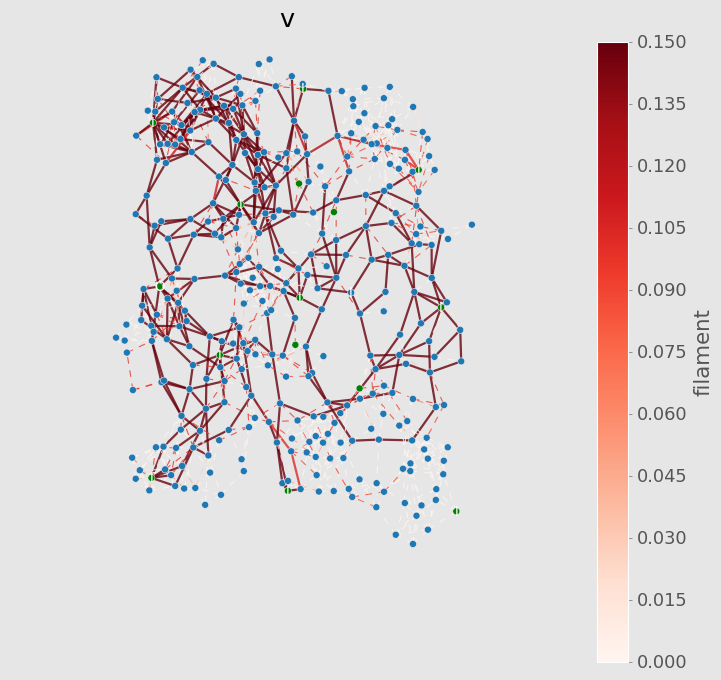

In [430]:
f=plt.figure()
timetoshow=(run_time*1000)-1
weights= simulation.junctionVoltage[timetoshow,:]*simulation.junctionConductance[timetoshow,:]
vmax = np.max(simulation.junctionVoltage * simulation.junctionConductance)
vmin = np.min(simulation.junctionVoltage * simulation.junctionConductance)

#Draw Currents:
# draw_graph(simulation,edge_colorbar=True,edge_mode='custom',edge_weight=weights,edge_vmax=vmax,edge_vmin=0,this_TimeStamp=timetoshow,node_size=100,node_highlight=drain_pool,with_labels=False)

# Draw Flimanets:
draw_graph(simulation,edge_colorbar=True,edge_mode='filament',this_TimeStamp=timetoshow,node_size=40,node_highlight=list(np.hstack((onSources,drain_pool))),highlight_color='g',with_labels=False,title='v')
# plt.savefig(saveFig+'class_v_50samples_10epochs_5sec_0p1V_filament_states_end_training_using_currents.pdf',format='pdf',dpi=300)

In [400]:
#Collate outputs

costs=[];finalCosts=[];
currents=[];finalCurrents=[];normCurrents=[];finalNormCurrents=[]
for i in range(len(outputs['cost'])):
    costs.append(outputs['cost'][i])
    a=np.sum(costs[i],axis=1)!=0
    finalCosts.append(costs[i][np.argwhere(a==True)[0][0]])
    currents.append(outputs['current'][i])
    a2=np.sum(currents[i],axis=1)!=0
    finalCurrents.append(currents[i][np.argwhere(a2==True)[-1][0]])
    normCurrents.append(outputs['normcurrent'][i])
    a3=np.sum(normCurrents[i],axis=1)!=0
    finalNormCurrents.append(normCurrents[i][np.argwhere(a3==True)[-1][0]])

Text(0.5, 0, 'epochs')

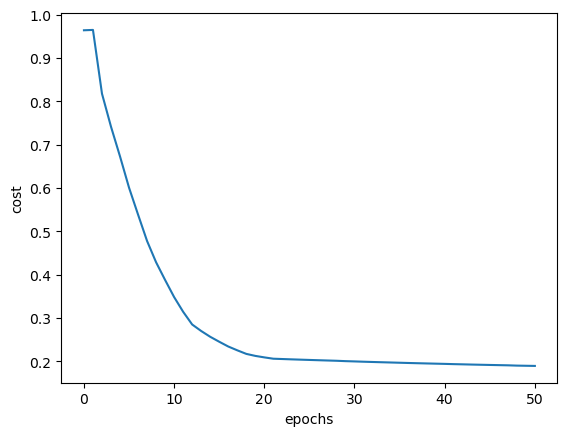

In [401]:
plt.plot(np.sum(finalCosts,axis=1))
plt.ylabel('cost')
plt.xlabel('epochs')
#visualise all epochs + samples (0 to 500)

Text(0, 0.5, 'Training Sample Iteration')

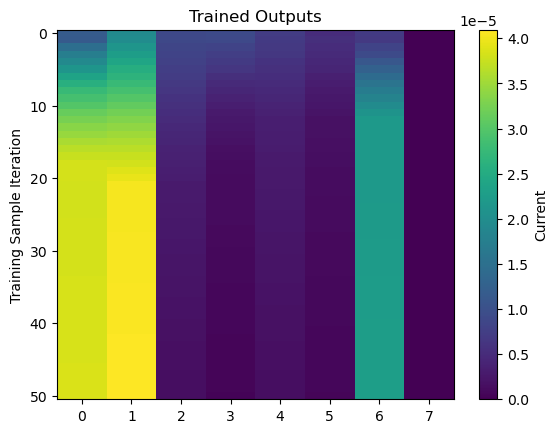

In [403]:
#visualise change in actual currents across the drains as a function of training samples

plt.imshow(finalCurrents,aspect='auto')
plt.colorbar(label='Current')
plt.title('Trained Outputs')
plt.ylabel('Training Sample Iteration')


In [404]:
new_states=[]
for i in range(len(network_state)):
    for j in range(len(network_state[i])):
        if network_state[i][j]:
            new_states.append(network_state[i][j])

In [442]:
# RUN TESTING WITH NEW DATA:

#Global Variables

costSV              = [[] for i in range(numClasses)]
costS               = [[] for i in range(numClasses)]
costV               = [[] for i in range(numClasses)]
costNone            = [[] for i in range(numClasses)]

numTestingSamples   = 1#len(testingInputs)
numClasses          = 3
seed                = 42 #random seed
thisNwState         = None #inital network state
np.random.seed(seed)
network_state_train = new_states[-1]#[i for i in network_state[-1] if i][-1] #last network state after training
network_state_test  = [[[] for i in range(numTestingSamples)] for i in range(numClasses)]
simtest             = [[[] for i in range(numTestingSamples)] for i in range(numClasses)]
trained             = [[[] for i in range(numTestingSamples)] for i in range(numClasses)]
allSources          = [[[] for i in range(numTestingSamples)] for i in range(numClasses)]
maxCurr             = [[[] for i in range(numTestingSamples)] for i in range(numClasses)]
stimulus_train      = copy.deepcopy(sim_stimulus)
#KEEP DRAIN VOLTAGES
drain_voltages      = False
use_network_state   = True

# targetClass = 2
for inputClass in tqdm(range(numClasses)): #for each class, z, v, n 
    for sample in (range(numTestingSamples)): #for each test sample
#         target_index = int(targets[targets==targetClassVals[targetClass]][sample]) #set target index
        if inputClass == targetClass: #if the class we're inputting is the target class
            currTest     =  NoNoiseInputs[inputClass]#[sample][:-1] #choose test sample inputs for desired class
        else:
            currTest     =  NoNoiseInputs[inputClass]#inputs[targets==inputClass][-sample][:-1] #choose test sample inputs for other classes       

        onSources=np.array(sources)[np.array(currTest)>0]
        allSources[inputClass][sample]=onSources
        offSources=np.array(sources)[currTest==0]
            
        print('---------- ')
        print('Class ' +str(target_letters[inputClass]))
        print('Test Sample ' +str(sample+1))

        epochs       = 1 #number of 'test' to run max, unless we hit 0.1 first
        onAmp        = 0.1 #amplitude for init
        run_time     = 6 # time for each iteration
        dt           = 0.001 #timesteps

        signalType   ='DC' #Pulse, DC, AC, Square, Sawtooth

        numtesting             = 1 #number of training iterations per epoch
        num_drain_testing      = 8 #total number of drain electrodes
        num_source_testing     = len(sources) #total number of source electrodes
        ttest                  = np.zeros((epochs,num_drain_testing))
        testing_stimulus       = []
           
        
        if drain_voltages: #if we keep drain_voltages from last training epoch
            testing_drain_stimulus = copy.deepcopy(stimulus_train[:num_drain_testing])
            for i in range(len(testing_drain_stimulus)):
                testing_drain_stimulus[i].signal=np.hstack([testing_drain_stimulus[i].signal])#*10)
            testing_stimulus       = setupSourcesOnly(testing_drain_stimulus,currTest,run_time=run_time,onAmp=onAmp)
            
        else: #if we reset drain voltages to 0, and just use network state in runSimulations
            testing_stimulus       = setupStimulus(testing_stimulus,currTest,onAmp=onAmp,signalType=signalType,run_time=run_time)

#         print('Drain Voltages '+str([testing_stimulus[0].signal[0],testing_stimulus[1].signal[0],testing_stimulus[2].signal[0]]))
        print('Source Voltages '+str([k.signal[0] for k in testing_stimulus][num_drain_testing:]))
        
        for i in range(epochs): #for each epoch
            if use_network_state:
                thisNwState = copy.deepcopy(network_state_train) #final state from training
            else:
                thisNwState = None

            #run training + change voltages - save network state after each epoch.
            ttest[i],r,network_state_test[inputClass][sample],simtest[inputClass][sample] = runSimulations(testing_stimulus,thisNwState,signalType,run_time=run_time)
            
            print('Currents '+str(ttest[i]))
            print('Voltages '+str(simtest[inputClass][sample].wireVoltage.T[drain_pool].T[0]))

            #normalise currents:
            normCurr = ttest[i]/maxCurrent#(t[i]-minCurrent)/(maxCurrent-minCurrent)#(t[i]-np.min(t[i]))/(np.max(t[i])-np.min(t[i]))#np.mean(t[i]))/np.std(t[i])
#         set_trace()
            if i ==0:
            #normalise thresholds:
                th  = 1 #target threshold range + 0.2
                th2 = minCurrent/maxCurrent #non-target threshold range + 0.2

            #calculate output currents of drains after each epoch
            #change the voltages of target and non-target drains to tune the network into using different pathways
           
#             currents2=np.array(normCurr)
#             maxCurr[inputClass][sample]=np.argmax(currents2)
#             print((currents2[target_values==targetClass][0]-abs(currents2[target_values!=targetClass][0]))/currents2[target_values==targetClass][0],(currents2[target_values==targetClass][0]-abs(currents2[target_values!=targetClass][1]))/currents2[target_values==targetClass][0])
#             if (currents2[target_values==targetClass][0]-abs(currents2[target_values!=targetClass][0]))/currents2[target_values==targetClass][0]>=0.25 and (currents2[target_values==targetClass][0]-abs(currents2[target_values!=targetClass][1]))/currents2[target_values==targetClass][0]>=0.25:
#                 trained[inputClass][sample]=True
#             else:
#                 trained[inputClass][sample]=False
        
            if use_network_state and drain_voltages:
                print('nw state and voltage')
                costSV[inputClass].append(runTesting(normCurr,th,th2))
            elif use_network_state and not drain_voltages:
                print('nw state and no voltage')
                costS[inputClass].append(runTesting(normCurr,th,th2))
            elif not use_network_state and drain_voltages:
                print('no nw state and voltage')
                costV[inputClass].append(runTesting(normCurr,th,th2))
            else:  
                print('no nw state and no voltage')
                costNone[inputClass].append(runTesting(normCurr,th,th2))      

#              cost2=np.array(cost[i,:])
#         if cost2[target_values==targetClass][0]<cost2[target_values!=targetClass][0] or cost2[target_values==targetClass][0]<cost2[target_values!=targetClass][1]:
#             print('Target Cost lower than 1 non-target cost\n')
#             break;
#         else:
#             print('Target Cost not lower than 1 non-target cost\n')
            
            
            

---------- 
Class z
Test Sample 1
Source Voltages [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Currents [2.01071742e-05 2.11279195e-05 9.01510463e-06 7.68803207e-06
 8.00144421e-06 7.57862609e-06 1.59896771e-05 5.55010276e-08]
Voltages [0. 0. 0. 0. 0. 0. 0. 0.]
nw state and no voltage
---------- 
Class v
Test Sample 1
Source Voltages [0.1, 0.1, 0.1, 0.1]
Currents [1.91922874e-05 2.04699533e-05 8.81363868e-06 6.37674758e-06
 4.98827491e-06 5.25658153e-06 1.00377603e-05 8.56096193e-09]
Voltages [0. 0. 0. 0. 0. 0. 0. 0.]
nw state and no voltage
---------- 
Class n
Test Sample 1
Source Voltages [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Currents [2.13406758e-05 2.08096342e-05 8.99521688e-06 8.45122773e-06
 7.18732993e-06 7.20732826e-06 1.46780116e-05 5.40234732e-08]
Voltages [0. 0. 0. 0. 0. 0. 0. 0.]
nw state and no voltage



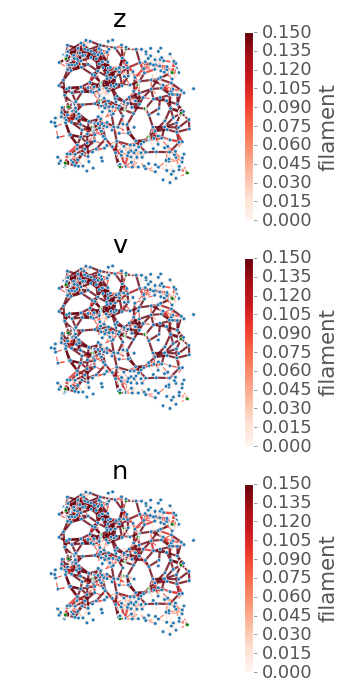

In [446]:
fig,axes=plt.subplots(3,1,figsize=(4,10))
timetoshow=run_time*1000-1

for i in range(len(simtest)):
    ax=axes[i]
    weights= simtest[i][0].junctionVoltage[timetoshow,:]*simtest[i][0].junctionConductance[timetoshow,:]
    vmax = 1e-5#np.max(simtest[i][j].junctionVoltage * simtest[i][j].junctionConductance)
    vmin = -1e-5#np.min(simtest[i][j].junctionVoltage * simtest[i][j].junctionConductance)
#         draw_graph(simtest[i][j],edge_colorbar=True,edge_mode='custom',edge_weight=weights,this_TimeStamp=timetoshow,node_size=20,title=target_letters[i],node_highlight=np.hstack((allSources[i][j],drain_pool)),highlight_color='g',ax=ax,with_labels=False)        
    draw_graph(simtest[i][0],edge_colorbar=True,edge_mode='filament',this_TimeStamp=timetoshow,node_size=10,node_highlight=list(np.hstack((allSources[i][0],drain_pool))),highlight_color='g',with_labels=False,title=target_letters[i],ax=ax)

# plt.savefig(saveFig+'class_v_currents_after_50sec_testing_using_currents_nwstate.pdf',format='pdf',dpi=300)
# plt.savefig(saveFig+'class_v_filament_states_after_10sec_testing_using_currents_nwstate.pdf',format='pdf',dpi=300)

In [458]:
dfS=pd.DataFrame([['z',np.sum(costS[0],axis=1)[0]],['v',np.sum(costS[1],axis=1)[0]],['n',np.sum(costS[2],axis=1)[0]]],columns=['Class','Cost'])

<AxesSubplot:title={'center':'NW State'}, xlabel='Class', ylabel='cost'>

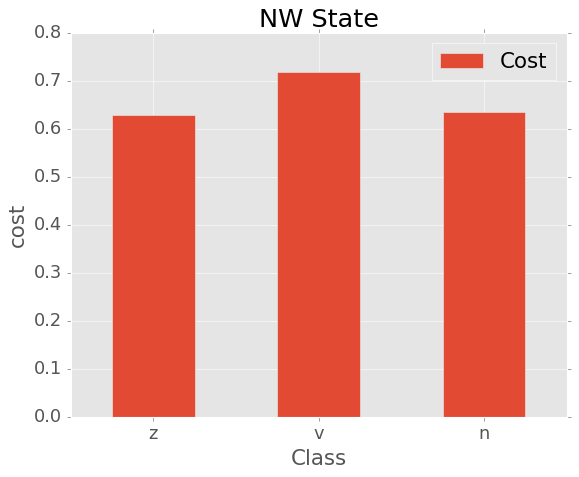

In [459]:
dfS.plot(x='Class', kind='bar', stacked=False,ylabel='cost',rot=0,title='NW State')

In [461]:
np.sum(costS[2],axis=1)[0]

0.6354041148569323